In [26]:
import osmnx as osm
import networkx as nx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [53]:
def make_barplot(title:str,y_axis:str,nodes:list[dict]|dict):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(nodes.keys(),nodes.values())
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    plt.title(title, fontsize=14)
    plt.xlabel("Node Label", fontsize=12)
    plt.ylabel(y_axis, fontsize=12)
    plt.xticks(list(nodes[0].keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [37]:
def determine_shortest_path(working_nodes):
    all_shortest_paths = {}
    for node in working_nodes.nodes():
        try:
            to_29 = nx.shortest_path_length(working_nodes, source=node, target=29)
            to_5 = nx.shortest_path_length(working_nodes, source=node, target=5)
            all_shortest_paths[node] = (to_29 + to_5)/2
        except nx.NetworkXNoPath:
            all_shortest_paths[node] = 0
    return all_shortest_paths

In [29]:
def plot_road_network(title,working_nodes):
    nodes, edges = ox.graph_to_gdfs(working_nodes)
    fig, ax = plt.subplots(figsize=(8, 8))
    edges.plot(ax=ax, color="blue", linewidth=1, alpha=0.8, label="Roads")
    nodes.plot(ax=ax, color="red", markersize=10, label="Intersections")
    for node_id, row in nodes.iterrows():
        x, y = row.geometry.x, row.geometry.y
        ax.text(x, y, str(row.name), fontsize=6, ha='center', va='center', color='black', alpha=0.7,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle="round,pad=0.2"))
    ax.set_title(title, fontsize=14)
    ax.legend()
    plt.show()
    print('Number of intersections:', working_nodes.number_of_nodes())
    print('Number of road segments:', working_nodes.number_of_edges())

In [41]:
# Define the target area
city = 'Hernesaari, Helsinki, Finland'

# Download the administrative boundaries
admin = ox.geocode_to_gdf(city)

# Download the road network, filtering for drivable roads
G = ox.graph_from_polygon(admin.geometry.to_list()[0], network_type='drive')

for i, node in enumerate(list(G.nodes())):
    G = nx.relabel_nodes(G, {node: i+1})


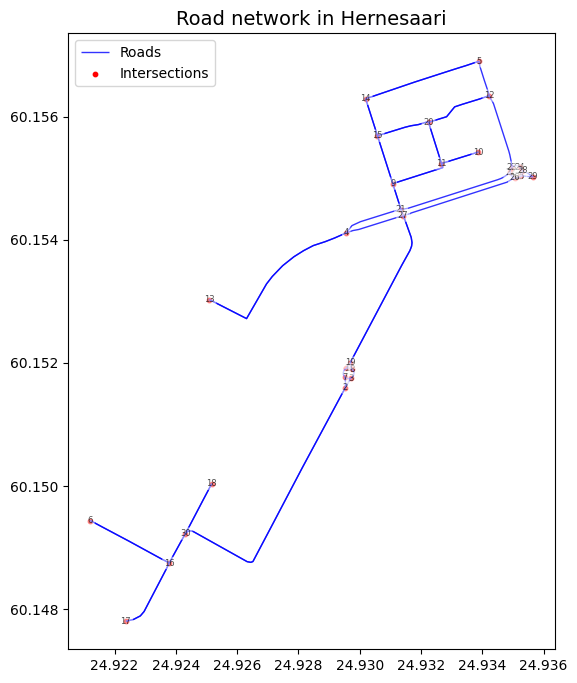

Number of intersections: 30
Number of road segments: 56


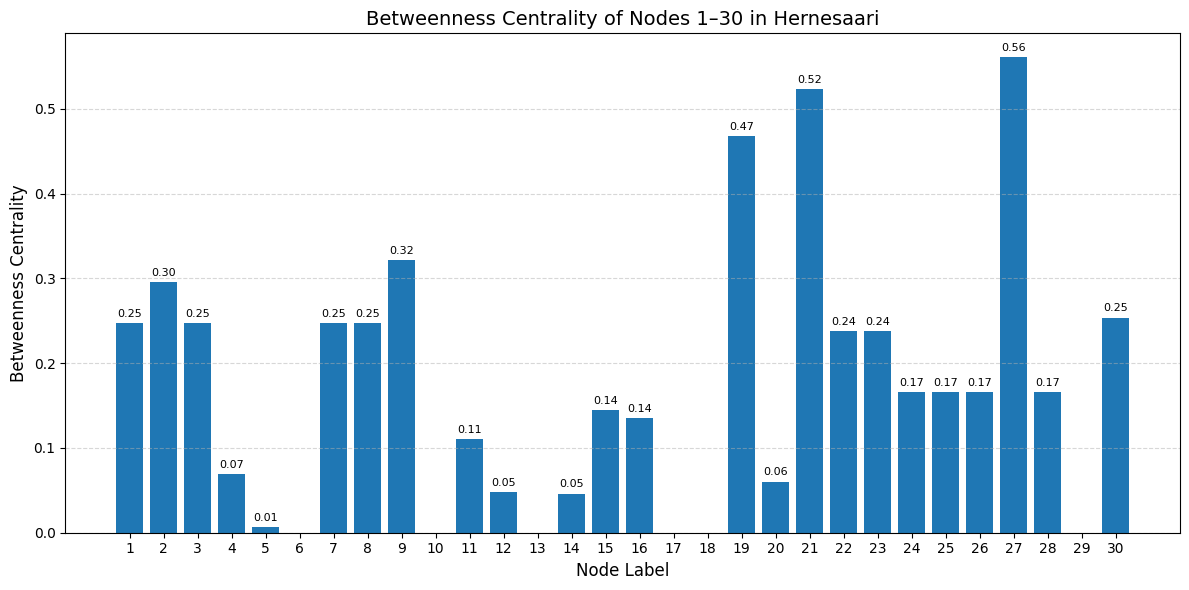

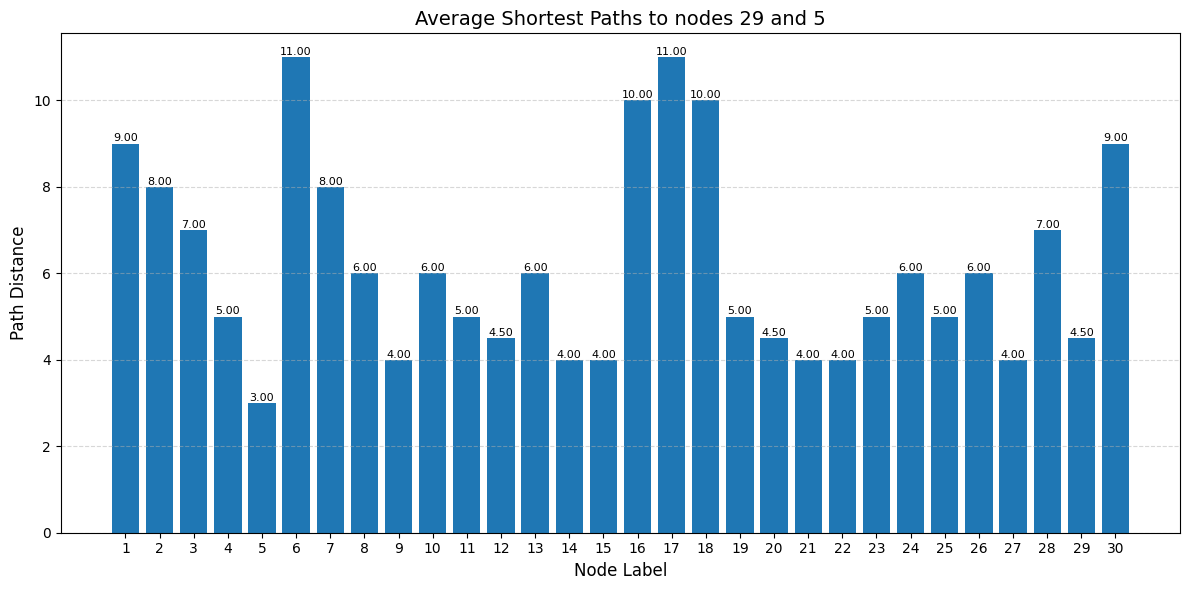

In [45]:
plot_road_network("Road network in Hernesaari",G)
centrality_full = nx.betweenness_centrality(G)
make_barplot("Betweenness Centrality of Nodes 1–30 in Hernesaari","Betweenness Centrality",centrality_full)
shortest_paths = determine_shortest_path(G)
make_barplot("Average Shortest Paths to nodes 29 and 5","Path Distance",shortest_paths)

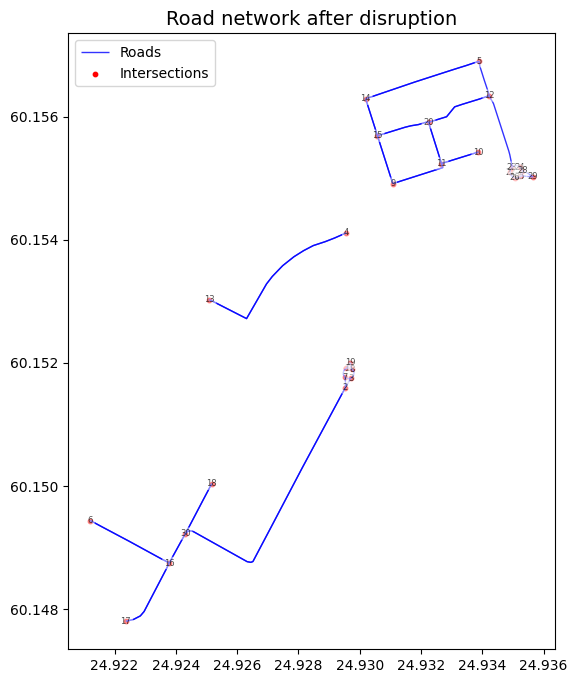

Number of intersections: 28
Number of road segments: 46


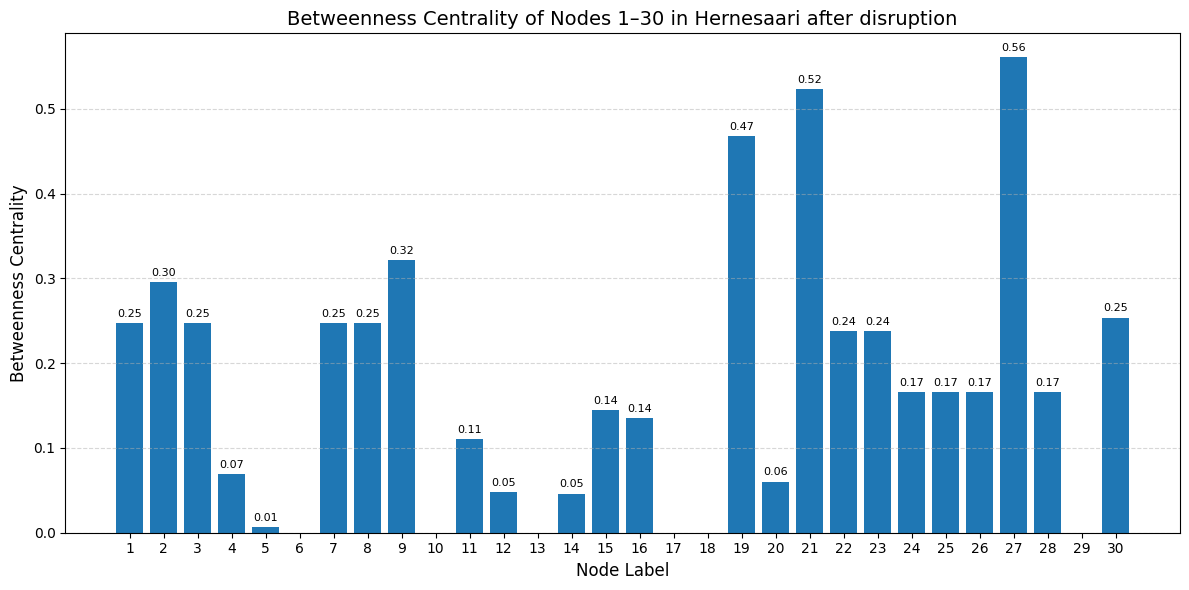

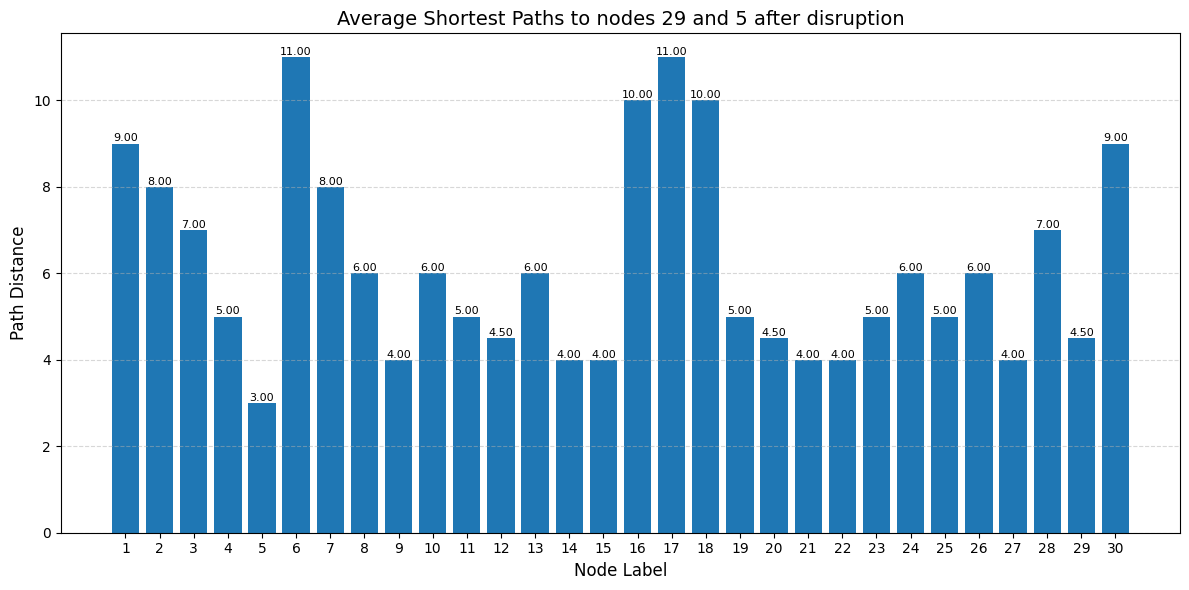

In [47]:
## Simulate the disruption by removing the edges connected to nodes 21 and 27
disrupted_nodes = [21, 27]
G_disrupted = G.copy()  # Make a copy of the graph to avoid modifying the original

# Remove the edges connected to the disrupted nodes
for node in disrupted_nodes:
    G_disrupted.remove_node(node)
    # if node in G_disrupted.nodes:
    #     # Remove incoming and outgoing edges from the disrupted nodes
    #     G_disrupted.remove_edges_from(list(G_disrupted.edges(node)))

plot_road_network("Road network after disruption",G_disrupted)
centrality_disrupted = nx.betweenness_centrality(G_disrupted)
make_barplot("Betweenness Centrality of Nodes 1–30 in Hernesaari after disruption","Betweenness Centrality",centrality_full)
shortest_paths_disrupted = determine_shortest_path(G_disrupted)
make_barplot("Average Shortest Paths to nodes 29 and 5 after disruption","Path Distance",shortest_paths)


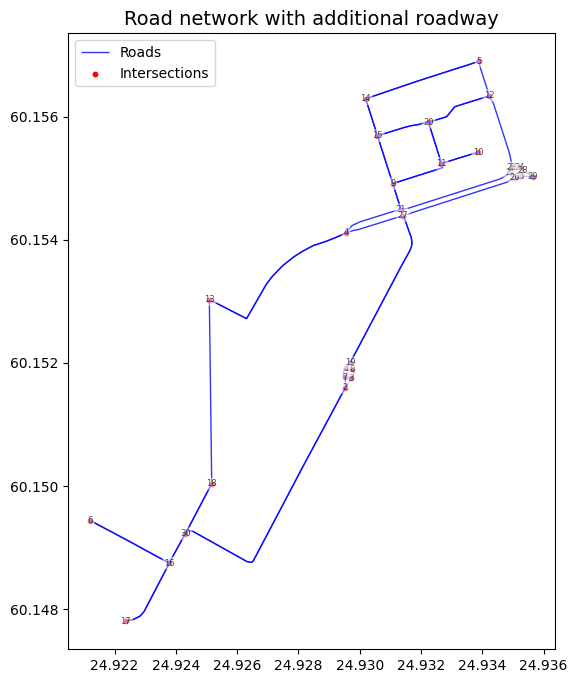

Number of intersections: 30
Number of road segments: 57


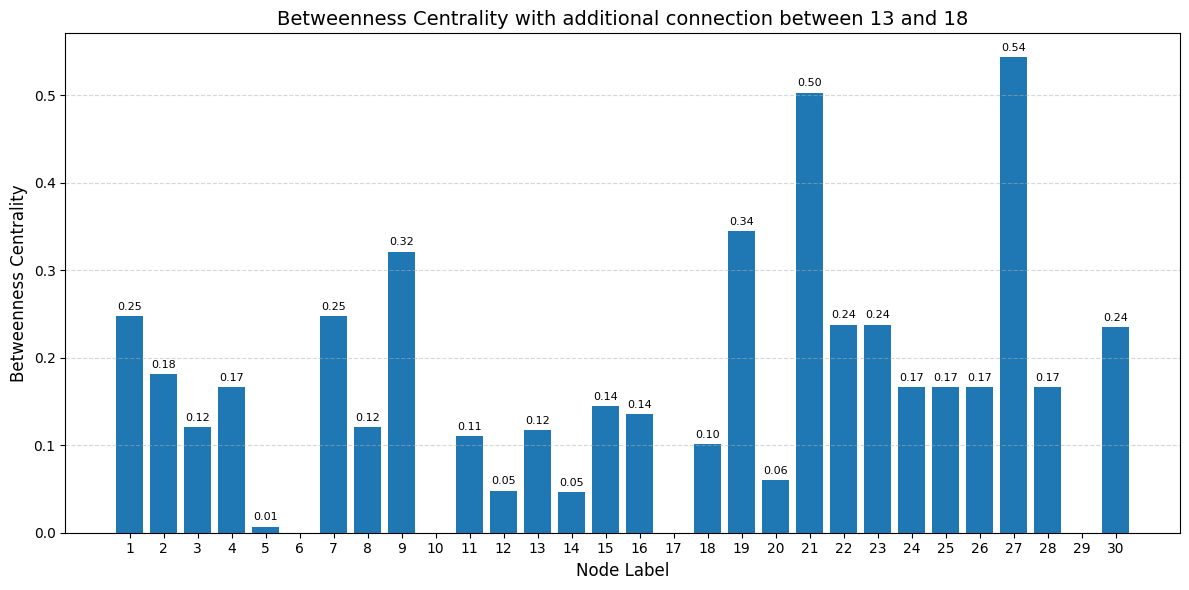

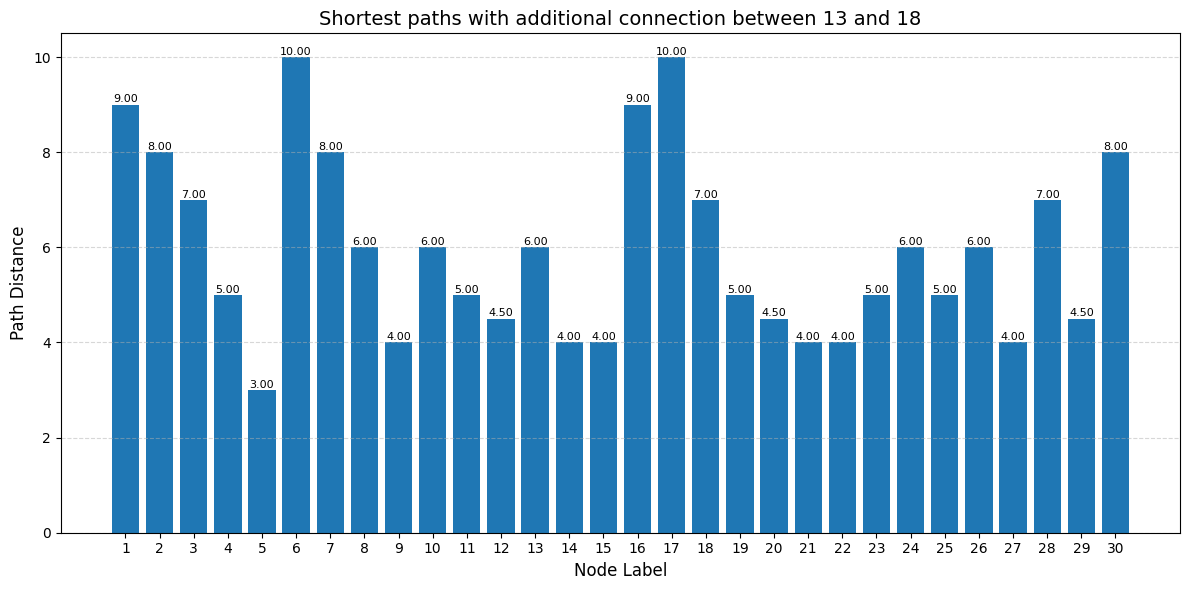

In [48]:
node_subset = G.copy()
for i, node in enumerate(list(node_subset.nodes())):
    node_subset = nx.relabel_nodes(node_subset, {node: i+1})
node_subset.add_edge(18, 13, length=ox.distance.euclidean(node_subset.nodes[18]['y'], node_subset.nodes[18]['x'], node_subset.nodes[13]['y'], node_subset.nodes[13]['x']))
plot_road_network("Road network with additional roadway",node_subset)
betweenness = nx.betweenness_centrality(node_subset)
make_barplot("Betweenness Centrality with additional connection between 13 and 18", "Betweenness Centrality", betweenness)
extra_shortest_paths = determine_shortest_path(node_subset)
make_barplot("Shortest paths with additional connection between 13 and 18","Path Distance",all_shortest_paths)


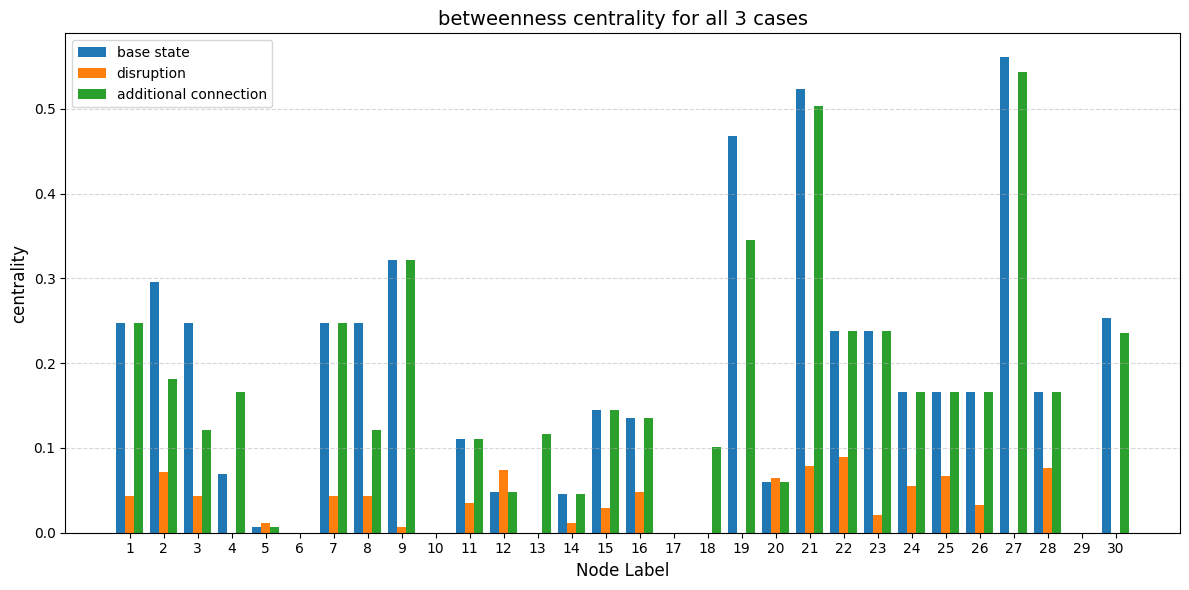

In [67]:
## Graphics
centrality_disrupted[21] = 0
centrality_disrupted[27] = 0
nodes = [centrality_full,centrality_disrupted,betweenness]
titles = ["base state","disruption","additional connection"]
labels = nodes[0].keys()
num_datasets = len(nodes)
plt.figure(figsize=(12, 6))
bar_width = 0.8 / num_datasets
for index,i in enumerate(nodes):
    x_pos = np.arange(len(labels)) + index * bar_width - (num_datasets - 1) * bar_width / 2 +1
    plt.bar(x_pos, i.values(), width=bar_width, label=titles[index])
plt.legend()
plt.title("betweenness centrality for all 3 cases", fontsize=14)
plt.xlabel("Node Label", fontsize=12)
plt.ylabel("centrality", fontsize=12)
plt.xticks(list(nodes[0].keys()))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

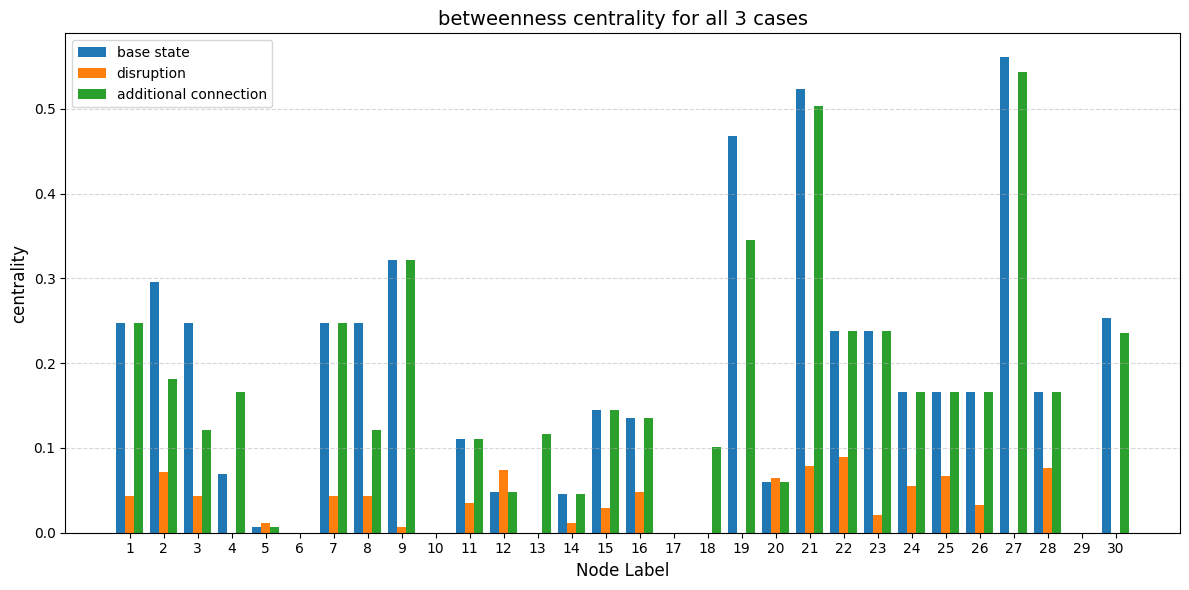

In [67]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABKUAAAJOCAYAAABm7rQwAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAle5JREFUeJzs3Xd4FFXbx/Hf7KaSkAQIEEJJqNJ7EVEpIkXkFUVFRQnIg6JiQ1RsFFEBBUVFxYZgAXl8VCwoiggovSNIh0Skg0CAUEJ25/1DdtlNdrNJCJMQvp/ryqU5e/bsfc+Zndm9OTMxTNM0BQAAAAAAAFjIVtABAAAAAAAA4NJDUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOYpSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsR1EKAFDkzJ07V4ZhaNiwYQUdClBoDBs2TIZhaO7cuV7thmGoTZs2BRLTmTNnNGzYMFWvXl2hoaEyDEPTp08vkFhyKjExUYmJiV5tkyZNkmEYmjRpUoHFBQDAxYiiFAAAeeDriymQG4W5eNq7d28ZhqGUlJQL+jpjx47V8OHDFR8fr0GDBmno0KGqWbPmBX3NwuDHH3/Ubbfdppo1ayomJkbFihVTzZo11bdvX23evLmgwwMAwDJBBR0AAAAACs6GDRtUrFixAnnt77//XpGRkZo1a5ZCQkIKJIaC8MMPP2jx4sVq0aKFOnfurODgYG3YsEGTJ0/WZ599ph9++EHt2rUr6DABALjgKEoBAABcwgpyZdLu3btVqlSpS6ogJUmvvPKK3nzzzSzts2fPVvv27fXkk09q2bJlBRIbAABW4vI9AECRNn/+fLVp00bFixdXTEyMunfvrq1bt/rsu3//fj366KOqVq2aQkNDFRsbq+7du2vdunXuPikpKTIMQ3/99Zf++usvGYbh/hk2bJgOHz4su92u66+/3mvs1atXu/tlfv02bdooPDxcp0+f9mr/7bff1LVrV8XGxio0NFTVq1fXs88+qxMnTviMP6f9PS8bW758ua699loVL15c0dHRuvHGG31esuW679C+ffuUlJSk2NhYhYeH6/LLL89yjyKXY8eOaejQoapTp47Cw8MVExOjjh07av78+Vn67tmzRw8//LCqV6/u7lurVi31799fqamp7n6pqakaMmSIateurcjISEVFRalatWpKSkrSX3/95TMOf9uqW7duKlu2rEJDQ1WxYkXddNNNWWIzTVMTJ05Uq1atFBUVpWLFiqlp06aaOHFiljE979k0ZcoUNWzYUOHh4SpXrpwefvhhnTx50qtv27ZtJUnDhw/32o9c2991Cd327ds1duxY1a5dW6Ghoerdu7d0tqAzdOhQXX755SpTpoxCQ0OVmJio+++/X/v378/xtsh8T6nExERNnjxZklS5cmV3XG3atFFqaqoiIiJUp04dn2M5nU4lJiaqRIkSXvn621bJycle76PMl8R+9NFHatGihSIjIxUZGakWLVr4vG+T5z69cOFCdejQQTExMTIMI2D+c+bM0d13363LLrvM/TpNmzbVe++9F/C5eRUWFuaz/ZprrlGJEiX8HqP8WbNmjXr27KkKFSooNDRU5cqVU6dOnfTdd9+5+6Smpmr06NFq3bq14uPjFRISovj4ePXq1Uvbtm3LMuapU6c0duxYNWjQQNHR0YqIiFBiYqJuvfVWrVmzJkv/b775xh1/WFiY6tatqzFjxsjhcHj1czqd+uCDD9S8eXOVLFlS4eHhqlChgrp27er3WAIAKLpYKQUAKLIWL16skSNHqlOnTnrwwQf1559/6uuvv9bvv/+uxYsXq0qVKu6+27ZtU5s2bbRz50516NBB3bp10/79+/Xll1/qp59+0uzZs9WiRQvFxMRo6NChGjdunCTpkUcecY/Rpk0blShRQg0aNNDvv/8uh8Mhu90unf3i6zJnzhxVq1ZNOvvFb/HixbriiisUGhrq7vPOO+/ogQceUExMjLp27aoyZcpo+fLlevHFFzVnzhzNmTPHa3VJbvtL0rJly/Tyyy+rbdu2uvfee7Vq1SpNnz5da9eu1bp167J8cT5y5IiuvPJKRUdH66677tL+/fs1bdo0dezYUStWrFDdunXdfQ8dOqSrr75af/75p1q1aqX+/fvr6NGj+uabb9S2bVt98cUX6tatmyTpxIkTatWqlVJSUtShQwfdeOONSk9PV3Jysj755BMNGjRI0dHRMk1THTt21JIlS9SqVSt16tRJNptNf/31l7799lvdddddSkhICLhfvP7663r00UcVHh6uG2+8UZUqVdKuXbs0f/58/e9//9OVV14pnS1I9ezZU1OnTlX16tV1xx13KCQkRLNmzVLfvn21fv16jRkzJsv448eP18yZM3XDDTeoXbt2mjlzpt544w0dPHhQn332mXtfSUlJ0eTJk9W6dWuvolBMTIzXeA8++KAWL16sLl26uOdWZwtrY8eO1TXXXKMWLVooODhYq1at0jvvvKOffvpJK1euVHR0dMDtkdkjjzyiSZMmac2aNXr44Yfd8SQmJio6Olq33XabJk6cqIULF+qKK67weu6sWbP0119/6YEHHlB4eLjf13Dlm/l95Jn7Qw89pDfffFPly5dX3759JUlffvml+vTpo1WrVun111/PMu7ChQv10ksvqW3btrrnnnu0Y8eOgPmOHj1aW7du1eWXX64bb7xRR44c0cyZM3Xvvfdq06ZNGjt2bA633PlbtGiRDh8+7N4Hc+LLL7/UHXfcIdM01bVrV1122WXav3+/lixZog8//FBdu3aVzl6mOWTIELVt21Y33nijIiIitHHjRk2ZMkUzZszQypUrvd4/SUlJ+u9//6v69eurT58+Cg0N1d9//605c+Zo2bJlatCggbvvU089pVGjRql8+fK66aabFB0drd9//12PP/64lixZoi+++MKr78svv6yqVavqjjvuUPHixd3vv19++aXAbroPACggJgAARcycOXNMSaYkc8KECV6PTZgwwZRkXn/99V7tV1xxhWm3282ZM2d6tW/atMksXry4Wa9ePa/2hIQEMyEhwefrDxw40JRkLlmyxN3WtWtXs0aNGmbFihXN22+/3d0+e/ZsU5L5/PPPu9v+/PNPMygoyGzQoIF58OBBr7FHjhxpSjLHjBmT5/6e2+fzzz/36n/XXXeZksypU6d6tbv633///abD4XC3f/DBB6Yk89577/Xqf8cdd5iSzPfff9+rfd++fWbFihXN0qVLmydPnjRN0zS//fZbU5L5yCOPZNmWx44dM0+dOmWapmn+8ccfpiSzW7duWfqdOnXKPHbsWJb2zFavXm3abDYzPj7eTE5O9nrM6XSau3btcv/+3nvvmZLMPn36mOnp6e7206dPm127djUlmcuXL3e3Dx061JRkRkdHmxs3bnS3nzhxwqxRo4Zps9m8xnfNw9ChQ33GmpSUZEoyK1SoYP71119ZHt+3b5/PnCdPnmxKMl944QWvdld8c+bM8WqXZLZu3drna2feRqZpmkuWLDElmb17987y2M0332xKMlevXu0zp8z8vY/mzZtnSjJr1aplHjlyxN1+6NAhs0aNGqYk87fffnO3e+7TEydOzNFru2zfvj1L25kzZ8xrr73WtNvtWba9r5g/+ugjU5L50Ucf5eq1f/rpJ3Po0KHm4MGDze7du5uhoaFmbGysuWzZshw9f+/evWZERIQZERFhrly5Msvjf//9t/v/jxw5Yv7zzz9Z+vz666+mzWYz//Of/3j1NQzDbNKkiZmRkeHVPyMjwzx8+LD7959//tmUZHbs2NE8fvy4u93pdJr9+/c3JZn/+9//3O0lS5Y04+PjzbS0tCyx+IoPAFC0cfkeAKDIqlGjhvr16+fV1q9fP1WvXl0zZszQgQMHJEmrVq3SwoULlZSUpI4dO/ocw7V6KCdcl2X9+uuvkiSHw6HffvtNbdu2Vdu2bbOsmpLHyhFJevfdd5WRkaE333xTpUqV8hr7iSeeUOnSpTV16tQ893e5+uqr1aNHD6+2u+++Wzq7iiqziIgIjR49WjbbuY8PSUlJCgoK8up/8OBBTZs2Te3atdN//vMfrzHKlCmjxx9/XAcOHNAvv/zi9ZivlTWRkZFeK8j89QsNDVVkZGSW9szeffddOZ1OvfDCC1kuFTMMQ/Hx8e7fx48fr4iICL311lsKDg52t4eEhOjFF1+UJJ/b9eGHH9Zll13mFe/tt98up9OpFStWBIwxs8cff1yVKlXK0l6mTBmfOd91112KiorKsn3zS/PmzdWoUSN98cUXOnr0qLv9wIED+vbbb9WsWTOvVTR54bp8cNiwYV6rvUqUKKGhQ4dKks/L+Bo3bqw+ffrk6rUqV66cpS0oKEj9+/eXw+Hwer/mt59//lnDhw/XqFGj9OWXX6pixYqaOXOmmjZtmqPnT548WWlpaXrsscfUqFGjLI9XqFDB/f/R0dEqWbJklj5t27ZVnTp1vPYXwzBkmqbCwsK83u+SZLfbvVa0jR8/XpL03nvvKSIiwmuMUaNGyTCMLO+TkJAQ9ypST77iAwAUbVy+BwAoslq1apXlC5XNZlOrVq20ZcsWrVmzRu3bt9fixYslSfv27dOwYcOyjLNx40b3fz0vUfPn6quvlt1u15w5czR48GCtWrVKqampateunU6cOKGPP/5YGzZsUK1atTRnzhyFh4erRYsW7ue74nFdNphZcHCwO6a89Hdp0qRJljbXl9gjR45keaxGjRpZiiBBQUEqW7asV/9ly5bJ4XDo9OnTPrfnli1bpLPb8/rrr9fVV1+tcuXKadSoUVqzZo2uv/56tW7dWrVq1fK6J1CtWrVUv359TZ06VTt37lS3bt3Upk0bNWzYMMs8+7N06VJJUocOHbLtd+LECa1du1bx8fEaPXp0lsfPnDnjziGz3G7XQJo3b+73sa+++krvvvuuVq5cqcOHD3vdv2f37t25fq2cuvfee9W/f39NmTJF/fv3lyR9/PHHSk9Pz1IIzotVq1ZJmYq1Lq6i7+rVq7M81qxZs1y/1rFjxzRmzBhNnz5d27ZtU1pamtfjF3I7jhkzRmPGjNHx48e1fv16Pf/882rVqpUmTpyoO+64I+Dzc7o/u8ydO1fjxo3TkiVLdPDgQWVkZLgf87y8NyoqStddd51++OEHNW7cWLfccovatGmjZs2aeRVodfb4ExER4fM+azpblPV8n9x22216++23VbduXd12221q27atWrZsme3lngCAoouiFACgyCpbtmy27a4baB86dEiSNGPGDM2YMcPveJm/rPoTFRWlxo0ba8GCBTpz5ozmzJkjwzDUtm1b903H58yZo4SEBC1dulStW7f2+kLoise1GieQ3Pb3jDOzoKB/Pxpkvjmxv/6u53j2d8WzYMECLViwwO/ru7ZndHS0Fi9erCFDhui7777TDz/8IEmqWLGiBg8erPvvv9/9Or/++quGDRumL7/8Uo899pgkqXTp0howYICeeeYZn6svPKWmpsowDJUrVy7bfocPH5Zpmtq1a5eGDx8eMAdPud2ugfjbj8eOHatBgwapdOnS6tChgypUqOD+Yj9u3LgsN87PT3fccYcGDRqkDz74wF2U+vDDDxUZGanbb7/9vMc/evSobDabSpcuneWxsmXLyjAMr1Vano/lRnp6utq0aaOVK1eqUaNGuuuuu1SqVCkFBQW57/l1IbejS2RkpJo3b67p06eradOmuueee3Tttdf6zN+T6xhWvnz5gK/xxRdfqEePHoqMjFTHjh2VmJioYsWKyTAMTZo0KcsfCvjiiy/00ksvacqUKXrmmWeks/t2nz599NJLL6lYsWLS2fd7RkZGjt8nr7/+uipXrqyPPvpIL7zwgl544QWFhYXp1ltv1dixYxUbGxswFwBA0UFRCgBQZO3bty/bdtdlQa4iwptvvqkBAwbky2u3bdtWy5Yt09KlSzV37lzVqVPH/QWzcuXKmjNnjqpXr64zZ864V364uOI5evSoihcvHvC1ctv/QnPF89hjj/m8EbgvlSpV0qRJk+R0OvXHH3/o559/1htvvKEHHnhAJUqUcBc6SpUqpTfffFNvvPGGNm7cqF9//VVvvvmmhg4dquDgYD311FPZvk5MTIxM09SePXuy/SLvyqFJkyZavnx5LrLPf77+glxGRoZGjBihcuXKafXq1e6bn+vsDdpffvnlCxpT8eLF1bNnT7377rtavXq10tLStGHDBv3nP//J0WWUgURFRcnpdOrAgQNeuensX8k0TdNn8S8nf23P0zfffKOVK1eqb9+++uCDD7we+/zzz92XEVolKChIbdu21Zo1a7R8+XJ17tw52/6uy+h27dqV5XLUzIYNG6awsDCtWLFC1atX93rs888/z9K/WLFi7qJRcnKy5syZowkTJuj111/XyZMn9e6770pn58owDB08eDDHOQ4aNEiDBg3S7t27NW/ePH300Uf6+OOPtXfvXv300085GgcAUDRwTykAQJG1YMECOZ1Orzan06mFCxfKMAz3fW9cl84tWrQox2Pb7fZsV724Ck0///yzfv/9d7Vr1879WLt27TR37lz3PacyX6Lkisd1WV4gue1/oTVr1kyGYeRqe7rYbDY1bNhQTzzxhPs+NN9++22WfoZhqFatWnrggQc0a9Ysv/0yc10K9/PPP2fbr3jx4qpVq5Y2bNiQp0vucsK1qisvq6cOHjyo1NRUtWzZMkvRZvny5Tp58uQFj+3ee++VJL3//vvugk5+XLonyX1/pLlz52Z5zNXWsGHD836dbdu2SZJuuOGGLI/9/vvv5z1+XrguF8x8mZwvOd2fdTbXWrVqZSlI7dmzR9u3b8/2uZUrV9bdd9+tefPmKTIy0uu91qJFC/3zzz/uy3JzIz4+XrfffrtmzpypatWq6ZdffjnvfRcAcHGhKAUAKLI2b96s999/36vt/fff1+bNm9WlSxf3yqXmzZurRYsWmjp1qqZNm5ZlHKfTqXnz5nm1lSxZUgcPHtSpU6d8vvaVV16poKAgvfPOOzp27JhXUapt27Y6ePCgPvzwQ0VERGS5D87999+voKAgPfjggz7/pP2RI0fc99zJS/8LLS4uTrfeeqsWLlyoV155Rf/+gTdvS5YscV/K+Oeff/pc1eZqCwsLkySlpKQoJSUlYL/s9O/fX3a7Xc8++2yWy5VM0/S6f9BDDz2kEydOqF+/fj4v00tOTvYZT065bur8999/5/q5ZcqUUXh4uFauXOnejjp72eGDDz6Y55hyE1ujRo3UrFkzffbZZ/riiy9Uv379bO9/lRtJSUmSpOHDh3tdppeamuq+TMzV53wkJCRIkubPn+/VPm/evCzHjvzkb/XdTz/9pK+//loxMTFq2bJlwHGSkpIUGRmpsWPH+rzH1q5du9z/n5CQoK1bt3q9106dOqX77rvPfY80lwMHDvj8ww6HDx/W6dOnvd5rDz30kHT2jyT8888/WZ6zd+9ebdiwQZJ0+vRpLVy4MEuftLQ0HT9+XMHBwTm+PxwAoGjg8j0AQJHVsWNHPfTQQ/rhhx9Up04d/fnnn/ruu+8UGxur119/3avv1KlT1bZtW912220aN26cGjdurPDwcO3YsUOLFi3SgQMHvApQ7dq1c19ec9VVVykkJERXX321rr76aunsPWKaNWumRYsWyWazqXXr1u7nulZRHThwQB07dsyyIqJu3bp6++23dd999+myyy7Tddddp6pVq+rYsWPavn275s2bp969e2vChAl56m+Ft99+W5s2bdITTzyhTz75RC1btlRMTIz+/vtvLV++XFu2bNGePXtUrFgxzZo1S48//rhatWqlGjVqqFSpUtq+fbu+/fZbhYWF6YEHHpDO3tj6pptuUvPmzVW7dm3FxcVp165dmj59umw2mx599NGAcdWrV0/jxo3TQw89pDp16qhbt25KSEjQ3r179dtvv6lLly4aN26cdHYl0OLFizV58mQtWLBA7du3V3x8vPbt26eNGzdqyZIlmjJlSsDLpvypWbOm4uPj9fnnnys0NFQVKlSQYRh68MEHvf7inC82m03333+/xo4dqwYNGqhr1646evSofvzxRyUkJHj9FcG8aNeuncaMGaN77rlH3bt3V0REhBISEnTXXXd59evfv7/69u0r5eMqKZ39YwEPPvig3nzzTdWtW1fdu3eXaZr68ssvtXPnTj300EPu99r56Nq1qxITE/Xyyy9r3bp1qlu3rjZt2qTvv/9eN954o/73v//lSz6ZNWvWTHXr1lX9+vVVoUIFpaWl6Y8//tDvv/+u4OBgTZw40esv2flTpkwZffzxx7rtttvUvHlz/d///Z8uu+wyHTx4UEuWLFFiYqKmT58uSXrwwQf14IMPqlGjRrr55puVkZGhWbNmyTRNNWjQQGvWrHGPu2vXLjVq1EgNGjRQ/fr1Vb58ef3zzz/65ptvdObMGQ0aNMjdt1OnTnruuec0YsQIVatWTZ06dVJCQoL++ecfbd26Vb///rteeOEF1apVSydPnnS/z5s0aaJKlSrp+PHj+v7777V3714NGjQoy1/bBAAUcSYAAEXMnDlzTEnm0KFDzd9//91s3bq1GRERYUZFRZk33nijuWXLFp/PO3TokPnss8+adevWNcPDw83IyEizevXq5h133GF+9dVXXn2PHTtm9uvXzyxXrpxpt9vdr+fp6aefNiWZTZo0yfJaNWrUMCWZI0eO9JvH0qVLzdtuu82Mj483g4ODzdjYWLNx48bm4MGDzQ0bNuS5v+f2ySw5OdmUZCYlJXm1SzJbt27tM86EhAQzISEhS/uJEyfMl19+2WzSpIkZERFhhoeHm5UrVza7detmfvzxx+aZM2dM0zTN9evXmw8//LDZqFEjs1SpUmZoaKhZpUoVMykpyfzzzz/d4/3999/m4MGDzcsvv9wsU6aMGRISYlaqVMm86aabzEWLFvndjr7MmTPHvP76682SJUuaISEhZoUKFczu3bubCxYsyNJ32rRpZvv27c0SJUqYwcHBZvny5c02bdqYY8eONQ8cOODuN3ToUFOSOWfOnCxjfPTRR6Yk86OPPvJqX7x4sdm6dWuzePHipiRTkpmcnGyapmkmJSV5/Z5Zenq6+eKLL5rVq1c3Q0NDzUqVKpmPPfaYeezYMZ9z4i8+f3P78ssvm9WrVzeDg4P99klLSzNDQ0PN8PBw8/Dhwz7jzI6/fcdl4sSJZrNmzcxixYqZxYoVM5s1a2ZOnDgxS7/s9ulAtm/fbnbv3t0sXbq0+zU+//xzv2P6itnf/Prz0ksvmddee61Zvnx5MyQkxAwLCzNr1Khh3nPPPeb69etzncOqVavMW2+91SxbtqwZHBxslitXzuzcubP5/fffu/s4nU5zwoQJZp06dcywsDAzLi7O7Nu3r7l//36zdevWpufXgsOHD5vDhg0zr776arNcuXJmSEiIGR8fb3bq1Mn88ccffcYwa9Yss2vXrmbp0qXN4OBgMy4uzmzZsqU5YsQIc8eOHaZ5dp8dPXq02aFDB7NChQpmSEiIWbZsWfPqq682p0yZYjqdzlznDgC4uBmmrzX1AAAAQADLly9Xs2bNdNddd+njjz8u6HAAAMBFhou2AQAAkCevvPKKJOm+++4r6FAAAMBFiHtKAQAAIMd27NihKVOm6M8//9R///tfdezYMUc35QYAAMiMy/cAAACQY3PnzlXbtm0VGRmptm3b6r333lNcXFxBhwUAAC5CFKUAAAAAAABgOe4pBQAAAAAAAMtRlAIAAAAAAIDlLvkbnTudTu3evVvFixeXYRgFHQ4AAAAAAMBFzTRNHTt2TPHx8bLZ/K+HuuSLUrt371bFihULOgwAAAAAAIAi5e+//1aFChX8Pn7JF6WKFy8und1QUVFRBR0OAAAAAADARe3o0aOqWLGiu+bizyVflHJdshcVFUVRCgAAAAAAIJ8Euk0SNzoHAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGC5S/6eUjnlcDh05syZgg4DKDRCQkKy/dOeAAAAAABkh6JUAKZpau/evTpy5EhBhwIUKjabTZUrV1ZISEhBhwIAAAAAuAhRlArAVZAqU6aMihUrFvDO8cClwOl0avfu3dqzZ48qVarE+wIAAAAAkGsUpbLhcDjcBalSpUoVdDhAoVK6dGnt3r1bGRkZCg4OLuhwAAAAAAAXGW4Ikw3XPaSKFStW0KEAhY7rsj2Hw1HQoQAAAAAALkIUpXKAS5OArHhfAAAAAADOB0UpAAAAAAAAWI6iVBHVpk0bPfLIIwUdBgAAAAAAgE/c6DyPEgfPsPT1UkZ1sfT1rJaSkqLKlStr1apVatiwYa6eaxiGvv76a3Xr1u2CxQcAAAAAAPIXK6UAAAAAAABgOYpSRVhGRoYGDBig6OhoxcbG6rnnnpNpmu7HP/nkEzVt2lTFixdXXFyc7rjjDu3fv9/9+OHDh9WzZ0+VLl1a4eHhql69uj766CP343///bduvfVWxcTEqGTJkrrhhhuUkpLiN57sxqtcubIkqVGjRjIMQ23atJEkLVu2TNdee61iY2MVHR2t1q1ba+XKle4xExMTJUk33nijDMNw/y5J33zzjRo3bqywsDBVqVJFw4cPV0ZGRj5tXQAAAAAAcD4oShVhkydPVlBQkJYuXarXX39dr776qj744AP342fOnNGIESO0Zs0aTZ8+XSkpKerdu7f78eeee07r16/Xjz/+qA0bNuidd95RbGys+7kdO3ZU8eLF9fvvv2vBggWKjIxUp06dlJ6e7jOe7MZbunSpJOmXX37Rnj179NVXX0mSjh07pqSkJM2fP1+LFy9W9erVdd111+nYsWPS2aKVJH300Ufas2eP+/fff/9dvXr10sMPP6z169fr3Xff1aRJk/Tiiy9eoK0NAAAAAAByg3tKFWEVK1bUa6+9JsMwdNlll2nt2rV67bXX1K9fP0nS3Xff7e5bpUoVvfHGG2rWrJmOHz+uyMhI7dixQ40aNVLTpk0lj1VJkjRt2jQ5nU598MEHMgxDOlsYiomJ0dy5c9WhQ4cs8WQ3XunSpSVJpUqVUlxcnLu9Xbt2XmO89957iomJ0bx583T99de7nxcTE+P1vOHDh2vw4MFKSkpy5zdixAg98cQTGjp06HluWQAAAAAAcL5YKVWEXX755e6CkSS1bNlSW7ZskcPhkCStWLFCXbt2VaVKlVS8eHG1bt1aOls8kqT77rtPn3/+uRo2bKgnnnhCCxcudI+1Zs0abd26VcWLF1dkZKQiIyNVsmRJnTp1Stu2bfMZT3bj+bNv3z7169dP1atXV3R0tKKionT8+HF3jP6sWbNGzz//vDu2yMhI9evXT3v27NGJEydyuAUBAAAAAMCFwkqpS1RaWpo6duyojh076rPPPlPp0qW1Y8cOdezY0X35XefOnfXXX3/phx9+0KxZs3TNNdfogQce0JgxY3T8+HE1adJEn332WZaxXauXMstuPH+SkpL0zz//6PXXX1dCQoJCQ0PVsmVLv5cIuhw/flzDhw/XTTfdlOWxsLCwHGwhAAAAAABwIVGUKsKWLFni9bvrnkx2u10bN27UP//8o1GjRqlixYqSpOXLl2cZo3Tp0kpKSlJSUpKuuuoqPf744xozZowaN26sadOmqUyZMoqKispxTP7GCwkJkST3Ki6XBQsW6O2339Z1110nnb25+sGDB736BAcHZ3le48aNtWnTJlWrVi3HsQEAAAAAAOtw+V4RtmPHDg0cOFCbNm3S1KlT9eabb+rhhx+WJFWqVEkhISF68803tX37dn377bcaMWKE1/OHDBmib775Rlu3btWff/6p77//XrVq1ZIk9ezZU7Gxsbrhhhv0+++/Kzk5WXPnztVDDz2knTt3+ownu/HKlCmj8PBwzZw5U/v27VNqaqokqXr16vrkk0+0YcMGLVmyRD179lR4eLjXuImJiZo9e7b27t2rw4cPu1/r448/1vDhw/Xnn39qw4YN+vzzz/Xss89egC0NAAAAAAByi6JUEdarVy+dPHlSzZs31wMPPKCHH35Y99xzj3R2xdKkSZP0xRdfqHbt2ho1alSWy+hCQkL01FNPqX79+rr66qtlt9v1+eefS5KKFSum3377TZUqVdJNN92kWrVqqW/fvjp16pTflVPZjRcUFKQ33nhD7777ruLj43XDDTdIkj788EMdPnxYjRs31l133aWHHnpIZcqU8Rp37NixmjVrlipWrKhGjRpJkjp27Kjvv/9eP//8s5o1a6bLL79cr732mhISEi7AlgYAAAAAALllmKZpFnQQBeno0aOKjo5WampqlmLKqVOnlJycrMqVK3MfIiAT3h8AAABA/kocPCNgn5RRXSyJBTgf2dVaPLFSCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoyh1CWnTpo0eeeQRSVJiYqLGjRtX0CH5ZRiGpk+fXtBhAAAAAACACySooAO4aA2Ltvj1UvN1uGXLlikiIiJfx8yLYcOGafr06Vq9erVX+549e1SiRIkCiwsAAAAAAFxYFKUuUaVLl87zc9PT0xUSEpKv8WQWFxd3QccHAAAAAAAFi8v3iqi0tDT16tVLkZGRKleunMaOHev1uOfle6ZpatiwYapUqZJCQ0MVHx+vhx56yKvviBEj1KtXL0VFRemee+7R3LlzZRiGjhw54u63evVqGYahlJQUSdKkSZMUExOj6dOnq3r16goLC1PHjh31999/ux8fPny41qxZI8MwZBiGJk2aJPm4fG/t2rVq166dwsPDVapUKd1zzz06fvy4+/HevXurW7duGjNmjMqVK6dSpUrpgQce0JkzZy7YNgYAAAAAAHlHUaqIevzxxzVv3jx98803+vnnnzV37lytXLnSZ98vv/xSr732mt59911t2bJF06dPV7169bz6jBkzRg0aNNCqVav03HPP5TiOEydO6MUXX9THH3+sBQsW6MiRI7rtttskST169NBjjz2mOnXqaM+ePdqzZ4969OiRZYy0tDR17NhRJUqU0LJly/TFF1/ol19+0YABA7z6zZkzR9u2bdOcOXM0efJkTZo0yV3kAgAAAAAAhQuX7xVBx48f14cffqhPP/1U11xzjSRp8uTJqlChgs/+O3bsUFxcnNq3b6/g4GBVqlRJzZs39+rTrl07PfbYY+7fXaudAjlz5ozGjx+vFi1auOOoVauWli5dqubNmysyMlJBQUHZXq43ZcoUnTp1Sh9//LH7Pljjx49X165dNXr0aJUtW1aSVKJECY0fP152u101a9ZUly5dNHv2bPXr1y9HsQIAAABAUVBvcr2AfdYmrbUkFiA7rJQqgrZt26b09HR3IUiSSpYsqcsuu8xn/1tuuUUnT55UlSpV1K9fP3399dfKyMjw6tO0adM8xRIUFKRmzZq5f69Zs6ZiYmK0YcOGHI+xYcMGNWjQwOvG7K1atZLT6dSmTZvcbXXq1JHdbnf/Xq5cOe3fvz9PcQMAAAAAgAuLohRUsWJFbdq0SW+//bbCw8N1//336+qrr/a6H1Pmv9Rns/2765im6W4r6Ps3BQcHe/1uGIacTmeBxQMAAAAAAPyjKFUEVa1aVcHBwVqyZIm77fDhw9q8ebPf54SHh6tr16564403NHfuXC1atEhr1/pfzun663179uxxt61evTpLv4yMDC1fvtz9+6ZNm3TkyBHVqlVLkhQSEiKHw5FtPrVq1dKaNWuUlpbmbluwYIFsNpvf1V8AAAAAAKBwoyhVBEVGRqpv3756/PHH9euvv2rdunXq3bu3e3VTZpMmTdKHH36odevWafv27fr0008VHh6uhIQEv69RrVo1VaxYUcOGDdOWLVs0Y8aMLH/hT2dXLz344INasmSJVqxYod69e+vyyy9337MqMTFRycnJWr16tQ4ePKjTp09nGaNnz54KCwtTUlKS1q1bpzlz5ujBBx/UXXfd5b6fFAAAAAAAuLhQlCqiXnnlFV111VXq2rWr2rdvryuvvFJNmjTx2TcmJkbvv/++WrVqpfr16+uXX37Rd999p1KlSvkdPzg4WFOnTtXGjRtVv359jR49Wi+88EKWfsWKFdOTTz6pO+64Q61atVJkZKSmTZvmfrx79+7q1KmT2rZtq9KlS2vq1Kk+x/jpp5906NAhNWvWTDfffLOuueYajR8/Ps/bBwAAAAAAFCzD9Lwp0CXo6NGjio6OVmpqqqKiorweO3XqlJKTk1W5cmWFhYUVWIwXq0mTJumRRx7RkSNHCjoUXAC8PwAAAID8lTh4RsA+KaO6BOzDX99DQcuu1uKJlVIAAAAAAACwHEUpAAAAAAAAWI6iFC6Y3r17c+keAAAAAADwiaIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilJwS0lJkWEYWr16td8+c+fOlWEYOnLkiCRp0qRJiomJCTi2YRiaPn16vsYbSOZYLzVt2rTRI488UtBhAAAAAADgU1BBB3Cxqje5nqWvtzZpraWvl1M9evTQdddd5/592LBhmj59epbC1p49e1SiRIkCiLDomzt3rtq2bavDhw97FQi/+uorBQcHF2hsAAAAiYNnBOyTMqqLJbEAAAoXilI4L+Hh4QoPDw/YLy4uzpJ4cE7JkiULOgQAAAAAAPzi8r0iaubMmbryyisVExOjUqVK6frrr9e2bdu8+ixdulSNGjVSWFiYmjZtqlWrVmUZ54cfflCNGjUUHh6utm3bKiUlxetxz8v3Jk2apOHDh2vNmjUyDEOGYWjSpEmSj8v31q5dq3bt2ik8PFylSpXSPffco+PHj7sf7927t7p166YxY8aoXLlyKlWqlB544AGdOXPG3eeTTz5R06ZNVbx4ccXFxemOO+7Q/v37c7Wdjhw5onvvvVdly5ZVWFiY6tatq++//979+Jdffqk6deooNDRUiYmJGjt2rNfzExMT9dJLL+nuu+9W8eLFValSJb333nvux12XRH711Vdq27atihUrpgYNGmjRokVe48yfP19XXXWVwsPDVbFiRT300ENKS0tzP3769Gk9+eSTqlixokJDQ1WtWjV9+OGHSklJUdu2bSVJJUqUkGEY6t27t+Tj8r3Dhw+rV69eKlGihIoVK6bOnTtry5YtWebyp59+Uq1atRQZGalOnTppz549udqmAAAAAADkBEWpIiotLU0DBw7U8uXLNXv2bNlsNt14441yOp2SpOPHj+v6669X7dq1tWLFCg0bNkyDBg3yGuPvv//WTTfdpK5du2r16tX6z3/+o8GDB/t9zR49euixxx5TnTp1tGfPHu3Zs0c9evTwGVvHjh1VokQJLVu2TF988YV++eUXDRgwwKvfnDlztG3bNs2ZM0eTJ0/WpEmT3EUuSTpz5oxGjBihNWvWaPr06UpJSXEXZHLC6XSqc+fOWrBggT799FOtX79eo0aNkt1ulyStWLFCt956q2677TatXbtWw4YN03PPPecVgySNHTvWXdS7//77dd9992nTpk1efZ555hkNGjRIq1evVo0aNXT77bcrIyNDkrRt2zZ16tRJ3bt31x9//KFp06Zp/vz5XtujV69emjp1qt544w1t2LBB7777riIjI1WxYkV9+eWXkqRNmzZpz549ev31133m27t3by1fvlzffvutFi1aJNM0dd1113kV+k6cOKExY8bok08+0W+//aYdO3Zk2S8AAAAAAMgPXL5XRHXv3t3r94kTJ6p06dJav3696tatqylTpsjpdOrDDz9UWFiY6tSpo507d+q+++5zP+edd95R1apV3auDLrvsMq1du1ajR4/2+Zrh4eGKjIxUUFBQtpfrTZkyRadOndLHH3+siIgISdL48ePVtWtXjR49WmXLlpXOrvwZP3687Ha7atasqS5dumj27Nnq16+fJOnuu+92j1mlShW98cYbatasmY4fP67IyMiA2+iXX37R0qVLtWHDBtWoUcM9jsurr76qa665Rs8995wkqUaNGlq/fr1eeeUVr+LXddddp/vvv1+S9OSTT+q1117TnDlzdNlll7n7DBo0SF26/HuvhOHDh6tOnTraunWratasqZEjR6pnz57uVU3Vq1fXG2+8odatW+udd97Rjh079N///lezZs1S+/bts8TpukyvTJkyfm86v2XLFn377bdasGCBrrjiCknSZ599pooVK2r69Om65ZZbpLOFvgkTJqhq1aqSpAEDBuj5558PuC0BAAAAAMgtVkoVUVu2bNHtt9+uKlWqKCoqSomJiZKkHTt2SJI2bNig+vXrKywszP2cli1beo2xYcMGtWjRwqstc5+82LBhgxo0aOAuSElSq1at5HQ6vVYY1alTx71qSZLKlSvndXneihUr1LVrV1WqVEnFixdX69atvXIMZPXq1apQoYK7IOUrzlatWnm1tWrVSlu2bJHD4XC31a9f3/3/hmEoLi4uy2WEnn3KlSsnSe4+a9as0aRJkxQZGen+6dixo5xOp5KTk7V69WrZ7XZ3fnmxYcMGBQUFec1nqVKldNlll2nDhg3utmLFirkLUvKxzQEAAAAAyC+slCqiunbtqoSEBL3//vuKj4+X0+lU3bp1lZ6eXtCh5VjmvxxnGIb78kPXJYAdO3bUZ599ptKlS2vHjh3q2LFjjnPMyQ3azzdOX30Mw5DOXj6os5dS3nvvvXrooYeyjF2pUiVt3bo1X+LMCV+5mKZp2esDAAAAAC4drJQqgv755x9t2rRJzz77rK655hrVqlVLhw8f9upTq1Yt/fHHHzp16pS7bfHixVn6LF261Kstc5/MQkJCvFYR+VKrVi2tWbPG60beCxYskM1m87rkLTsbN27UP//8o1GjRumqq65SzZo1c72ip379+tq5c6c2b97sN84FCxZ4tS1YsEA1atTwWsF1vho3bqz169erWrVqWX5CQkJUr149OZ1OzZs3z+fzQ0JCJCnb7V6rVi1lZGRoyZIl7jbXflK7du18ywUAAAAAgJyiKFUElShRQqVKldJ7772nrVu36tdff9XAgQO9+txxxx0yDEP9+vXT+vXr9cMPP2jMmDFeffr3768tW7bo8ccf16ZNmzRlypQsN/nOLDEx0X3J2cGDB3X69OksfXr27KmwsDAlJSVp3bp1mjNnjh588EHddddd7vtJBVKpUiWFhITozTff1Pbt2/Xtt99qxIgROXquS+vWrXX11Vere/fumjVrlpKTk/Xjjz9q5syZkqTHHntMs2fP1ogRI7R582ZNnjxZ48ePz/cbfz/55JNauHChBgwYoNWrV2vLli365ptv3Dc6T0xMVFJSku6++25Nnz5dycnJmjt3rv773/9KkhISEmQYhr7//nsdOHDA668YulSvXl033HCD+vXrp/nz52vNmjW68847Vb58ed1www35mg8AAAAAADlBUaoIstls+vzzz7VixQrVrVtXjz76qF555RWvPpGRkfruu++0du1aNWrUSM8880yWG5hXqlRJX375paZPn64GDRpowoQJeumll7J97e7du6tTp05q27atSpcuralTp2bpU6xYMf300086dOiQmjVrpptvvlnXXHONxo8fn+McS5curUmTJumLL75Q7dq1NWrUqCxFtZz48ssv1axZM91+++2qXbu2nnjiCfeKo8aNG+u///2vPv/8c9WtW1dDhgzR888/n6u/8JcT9evX17x587R582ZdddVVatSokYYMGaL4+Hh3n3feeUc333yz7r//ftWsWVP9+vVzrzQrX768hg8frsGDB6ts2bJZ/oqhy0cffaQmTZro+uuvV8uWLWWapn744Ycsl+wBAAAAAGAFw7zEbxhz9OhRRUdHKzU1VVFRUV6PnTp1SsnJyapcubLXDcEB8P4AAAA5kzh4RsA+KaO6WBILUNjl1/ul3uR6AfusTVqb47iA3Mqu1uKJlVIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWK5RFqbfeekuJiYkKCwtTixYttHTpUr99J02aJMMwvH646TIAAAAAAEDhVuiKUtOmTdPAgQM1dOhQrVy5Ug0aNFDHjh21f/9+v8+JiorSnj173D9//fVXvsbkdDrzdTygKLjE/3AnAAAAAOA8BRV0AJm9+uqr6tevn/r06SNJmjBhgmbMmKGJEydq8ODBPp9jGIbi4uLyPZaQkBDZbDbt3r1bpUuXVkhIiAzDyPfXAS42pmnqwIEDMgxDwcHBBR0OAAC4BPAn7gGg6ClURan09HStWLFCTz31lLvNZrOpffv2WrRokd/nHT9+XAkJCXI6nWrcuLFeeukl1alT57zjsdlsqly5svbs2aPdu3ef93hAUWIYhipUqCC73V7QoQAAAAAALkKFqih18OBBORwOlS1b1qu9bNmy2rhxo8/nXHbZZZo4caLq16+v1NRUjRkzRldccYX+/PNPVahQIUv/06dP6/Tp0+7fjx49KklyOBxyOBzS2S/bNptNTqdTdrtd5cuXdz/uave8dMlms8kwDL/trnE92+XjskB/7Xa7XaZperW7YvTXnjmW3LaTEzkFyikoKMjrNYpCTkVxnsiJnMiJnMiJnAo6J7vhfcm/wzRkyJTN4wIEp9MZMHa7zv1DmClTTnm36exqbuaJnC7mnCRThuT1/lCm903mz9++cpIkm2wyZHiM/O/7xtUe6HM880RO55NT5tf1p1AVpfKiZcuWatmypfv3K664QrVq1dK7776rESNGZOk/cuRIDR8+PEv7tm3bFBkZKUmKjo5WuXLltG/fPqWmprr7xMbGKjY2Vn///bfS0tLc7XFxcYqJidH27duVnp7ubq9QoYIiIyO1efNmr4mqXLmygoKCtGXLFq8YqlevroyMDK97YtlsNtWoUUPHjx/Xzp073e0hISGqUqWKjhw5or1797rbIyIiVLFiRR08eFAHDx50t7ty2rNnDzmR0wXN6dChQz5z8vd+2rVrl8+cUlJSfOa0bdu2XOWUnJycJae0tDSfOaWmppITOZETOZETOZFTPud0bflzYxw/Y2j+PkPlI6S6Jc6179q1K2BOrcNau9uTM5KVnJGsesH1VNJe0t2emprKPJHTRZ2T3ZDC7dKVcef6ZjgN/bLbUKkwqWms0/2c7HKSpISgBFUOquxu352xWxszNqpGUA3FB8W7x2GeyOlC5JSSkqKcMMxCdLfi9PR0FStWTP/73//UrVs3d3tSUpKOHDmib775Jkfj3HLLLQoKCtLUqVOzPOZrpZRro0VFRUlFqDJZFKut5ERO5ERO5ERO5ERO5HRx5VTt6Rle7b5WSm158bqAsTf+pLG73d9KqVW9VjFP5HRR51T1mR8DrpTa/ELngDk1+KRBwJVSK+5cYUlORXGeyClwTqmpqSpZsqRSU1PdtRZfCtVKqZCQEDVp0kSzZ892F6WcTqdmz56tAQMG5GgMh8OhtWvX6rrrrvP5eGhoqEJDQ7O02+32LPfGcU1KZrlt93fPndy0G4aRq/b8ip2cyImcyCkv7eRETuRETtm1k9OllZPDzPqHgkwZcnj807grhuxidCjrpSCZ2wzXZUvMEzldtDkZMiWv94eL632T+Tn+cnIq86WB3u3n+/330p4n/+3k9G8s/sbPrFAVpSRp4MCBSkpKUtOmTdW8eXONGzdOaWlp7r/G16tXL5UvX14jR46UJD3//PO6/PLLVa1aNR05ckSvvPKK/vrrL/3nP/8p4EwAAAAAAADgT6ErSvXo0UMHDhzQkCFDtHfvXjVs2FAzZ8503/x8x44dXhXAw4cPq1+/ftq7d69KlCihJk2aaOHChapdu3YBZgEAAAAAAIDsFLqilCQNGDDA7+V6c+fO9fr9tdde02uvvWZRZAAAAAAAAMgPvi86BAAAAAAAAC4gilIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOYpSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJYLKugAAAAAgKIkcfCMgH1SRnWxJBYAAAozVkoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOYpSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOYpSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYrlAWpd566y0lJiYqLCxMLVq00NKlS3P0vM8//1yGYahbt24XPEYAAAAAAADkXaErSk2bNk0DBw7U0KFDtXLlSjVo0EAdO3bU/v37s31eSkqKBg0apKuuusqyWAEAAAAAAJA3ha4o9eqrr6pfv37q06ePateurQkTJqhYsWKaOHGi3+c4HA717NlTw4cPV5UqVSyNFwAAAAAAALlXqIpS6enpWrFihdq3b+9us9lsat++vRYtWuT3ec8//7zKlCmjvn37WhQpAAAAAAAAzkdQQQfg6eDBg3I4HCpbtqxXe9myZbVx40afz5k/f74+/PBDrV69Okevcfr0aZ0+fdr9+9GjR6Wzq60cDockyTAM2Ww2OZ1Omabp7uuv3WazyTAMv+2ucT3bJcnpdOao3W63yzRNr3ZXLP7acxo7OZETOZETOZETOZETOeVvTnbDlNOUTEl2wyt0OUzJOPvZ82LKKbv5CDRPdsP0aneYhgyZsnlsG6fTGTB2u+zudlOmnPJukyTTNC/pfY+cLv6cJFOG5PX+UKb3Tebvrb5ykiSbbDJkeIz87/vG1R7o+y/zRE7nk1Pm1/WnUBWlcuvYsWO666679P777ys2NjZHzxk5cqSGDx+epX3btm2KjIyUJEVHR6tcuXLat2+fUlNT3X1iY2MVGxurXbt2KS0tzd0eFxenmJgYpaSkKD093d1eoUIFRUZGatu2bV4TVblyZQUFBWnLli1eMVSvXl0ZGRlKTk52t9lsNtWoUUNpaWnauXOnuz0kJERVqlRRamqq9u7d626PiIhQxYoVdejQIR08eNDdTk7kRE7kRE7kRE7kRE7W5HRteafm77XppOPf//c0a5dN4XZ55Xox5HQ+8+S5DY6fMTR/n6HyEVLdEufad+3aFTCn1mGt3e3JGclKzkhWveB6Kmkv6W5PTU29pPc9crr4c7IbUrhdujLuXN8Mp6FfdhsqFSY1jXW6n5NdTpKUEJSgykGV3e27M3ZrY8ZG1QiqofigePc4zBM5XYicUlJSlBOG6VlKK2Dp6ekqVqyY/ve//3n9Bb2kpCQdOXJE33zzjVf/1atXq1GjRrLbz/0LiWtj22w2bdq0SVWrVvV6jq+VUq6NFhUVJRWhymRRrLaSEzmREzmREzmREzkV9pxqPPtjwJVSW1/sfFHllN18BJqnak/PyLQNsq6U2vLidQFjb/xJY3e7v5VSq3qtuqT3PXK6+HOq+syPAVdKbX6hc8CcGnzSIOBKqRV3rrAkp6I4T+QUOKfU1FSVLFlSqamp7lqLL4VqpVRISIiaNGmi2bNnu4tSTqdTs2fP1oABA7L0r1mzptauXevV9uyzz+rYsWN6/fXXVbFixSzPCQ0NVWhoaJZ2u93uVdySx6Rkltv2zOPmpd0wjFy151fs5ERO5EROeWknJ3IiJ3LKrr2o5+QwDY//z9rXvAhzymu7YRhe28PFlOG1bVwxZBejQ1kvBcncZrguW7pE9728tpNTYcrJkOn32PHv+ybzc/zl5FTmSwO928/3+++lPU/+28np31j8jZ9ZoSpKSdLAgQOVlJSkpk2bqnnz5ho3bpzS0tLUp08fSVKvXr1Uvnx5jRw5UmFhYapbt67X82NiYiQpSzsAAAAAAAAKj0JXlOrRo4cOHDigIUOGaO/evWrYsKFmzpzpvvn5jh07/FYAAQAAAAAAcHEodEUpSRowYIDPy/Ukae7cudk+d9KkSRcoKgAAAAAAAOQXlhwBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOYpSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOWCCjoAAAAAAFnVm1wvYJ+1SWstiQUAgAuBlVIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy+W5KDVt2jSdOnUqf6MBAAAAAADAJSHPRanbb79dcXFx6tu3r+bMmZO/UQEAAAAAAKBIy3NRav78+erZs6e+++47tW/fXpUqVdLgwYO1bt26/I0QAAAAAAAARU6ei1JXXHGF3nrrLe3evVvffPONWrVqpfHjx6tBgwZq2LChxo4dqz179uRvtAAAAAAAACgSzvtG50FBQbr++us1depU7d27V5MmTVKpUqX0xBNPqFKlSrr22mv16aefKj09PX8iBgAAAAAAwEUvX//63rp167R06VKtXbtWpmmqZs2a+ueff9SrVy9VrVpV8+fPz8+XAwAAAAAAwEXqvItSmzdv1tChQ1W9enW1atVK//3vf3XHHXdo+fLlWrt2rVauXKmlS5eqZMmS6t+/f/5EDQAAAAAAgItaUF6f+Prrr+uzzz7TihUrFBoaqq5du2rcuHHq1KmT7Ha7V9+mTZtq4MCB6tu3b37EDAAAAAAAgItcnotSjz76qFq1aqUJEybo1ltvVXR0dLb9mzZtqueeey6vLwcAAAAAAIAiJM9FqW3btqly5co57l+nTh3VqVMnry8HAAAAAACAIiTP95Tq27evZs+e7ffxOXPmqF27dnkdHgAAAAAAAEVYnotSc+fO1b59+/w+vn//fs2bNy+vwwMAAAAAAKAIO6+/vmcYht/Htm7dquLFi5/P8AAAAAAAACiicnVPqcmTJ2vy5Mnu31944QW9//77WfodOXJEf/zxh6677rr8iRIAAAAAAABFSq6KUidOnNCBAwfcvx87dkw2m/diK8MwFBERof79+2vIkCH5FykA4IJKHDwjYJ+UUV0C9qk3uV7APmuT1uY4LgAAAABFU66KUvfdd5/uu+8+SVLlypX1+uuv6//+7/8uVGwAAAAAAAAoonJVlPKUnJycv5EAAAAAAADgkpHjotSOHTskSZUqVfL6PRBXfwAAAAAAAMAlx0WpxMREGYahkydPKiQkxP17IA6H43xjBAAAAAAAQBGT46LUxIkTZRiGgoODvX4HAAAAAAAAcivHRanevXtn+zsAAAAAAACQU7aCDgAAAAAAAACXnhyvlHr++edzPbhhGHruuedy/TwAAAAAAAAUbTkuSg0bNizXg1OUAgAAAAAAgC85Lko5nc4LGwkAAAAAAAAuGdxTCgAAAAAAAJajKAUAAAAAAADL5fjyPV/++OMPvfnmm1q5cqVSU1OzXOJnGIa2bdt2vjECAAAAAACgiMnzSqm5c+eqefPm+v777xUfH6/t27erSpUqio+P119//aXIyEhdffXVeRr7rbfeUmJiosLCwtSiRQstXbrUb9+vvvpKTZs2VUxMjCIiItSwYUN98skneU0LAAAAAAAAFshzUWrIkCGqUqWKNm3apI8++kiS9PTTT2v+/PlauHChdu7cqVtvvTXX406bNk0DBw7U0KFDtXLlSjVo0EAdO3bU/v37ffYvWbKknnnmGS1atEh//PGH+vTpoz59+uinn37Ka2oAAAAAAAC4wPJclFq5cqX69u2rqKgo2e12SZLD4ZAktWjRQvfee6+ee+65XI/76quvql+/furTp49q166tCRMmqFixYpo4caLP/m3atNGNN96oWrVqqWrVqnr44YdVv359zZ8/P6+pAQAAAAAA4ALL8z2lgoKCVLx4cUlSTEyMgoODvVYzValSRevXr8/VmOnp6VqxYoWeeuopd5vNZlP79u21aNGigM83TVO//vqrNm3apNGjR/vsc/r0aZ0+fdr9+9GjR6WzBTVXUc0wDNlsNjmdTpmm6e7rr91ms8kwDL/trnE92yVluQeXv3a73S7TNL3aXbH4a89p7ORETuRETq52SbIZpgyPsU1TcsqQ3fi3ryvW7HKSJLvsXjE65ZQp093uOc6FzKkozhM5kRM5Ff6c7IYppymZkuyeB1VJDlMyPI6D2eVkl10OOWTIkC3TvyU75JBNNq9xCus8uc4h57aBIUOmbB7bxul0Bozd89xiypRTziznG9M0L+l9j5wu/pykfz+L2bIcO869bzJ/b/WVkyTZZJPh8cnO9b5xtQf6/ss8kdP55JT5df3Jc1GqWrVq2rJli/uFa9asqa+//lo9e/aUJM2YMUNxcXG5GvPgwYNyOBwqW7asV3vZsmW1ceNGv89LTU1V+fLldfr0adntdr399tu69tprffYdOXKkhg8fnqV927ZtioyMlCRFR0erXLly2rdvn1JTU919YmNjFRsbq127diktLc3dHhcXp5iYGKWkpCg9Pd3dXqFCBUVGRmrbtm1eE1W5cmUFBQW5t59L9erVlZGRoeTkZHebzWZTjRo1lJaWpp07d7rbQ0JCVKVKFaWmpmrv3r3u9oiICFWsWFGHDh3SwYMH3e3kRE7kRE6BcpKk2jGmKkScO5ltPWpo61FDjUqZig0z3TFll5MktQptpSDj3ClmyeklOmWeUuuw1pLkHod5IidyIqeimNO15Z2av9emk45//9/TrF02hdvllau/nJqGNNWS9CWKs8epVnAtd/shxyGtPrNaCUEJXuMU1nny3AbHzxiav89Q+Qipbolz7bt27Qo4T65ziCQlZyQrOSNZ9YLrqaS9pLs9NTX1kt73yOniz8luSOF26cq4c30znIZ+2W2oVJjUNNbpfk52OUlSQlCCKgdVdrfvztitjRkbVSOohuKD4t3jME/kdCFySklJUU4YpmcpLReGDBmiiRMnKiUlRUFBQZo8ebL69OmjqlWrSmeLPCNHjtSTTz6Z4zF3796t8uXLa+HChWrZsqW7/YknntC8efO0ZMkSn89zOp3avn27jh8/rtmzZ2vEiBGaPn262rRpk6Wvr5VSro0WFRUlFaHKZFGstpITOZHThcupytM/BlwptfmFzgFzqv9x/YArpVbcucKSnIriPJETOZFT4c+pxrM/BlwptfXFzgFzavJpk4ArpVbeudKSnLKbj0DzVO3pGZm2QdaVUltevC5g7I0/aexu97dSalWvVZf0vkdOF39OVZ/5MeBKKdfnsexyavBJg4ArpVyfx5gncroQOaWmpqpkyZJKTU1111p8yfNKqeeee04PP/yw+35SSUlJstvt+vLLL2W32/XMM8+od+/euRozNjZWdrtd+/bt82rft29ftquubDabqlWrJklq2LChNmzYoJEjR/osSoWGhio0NDRLu91ud+fiOa6/18tNe+Zx89JuGEau2vMrdnIiJ3K6tHJymobPdsfZ9pweJx3yvVzX1Z55HOaJnMiJnHLbXphzcngcSx0+/vnXzGFOrmOmKdPncdUp5wXNNb/myeHj3GLK8No2rhiyi9HXNsjcZrguW7pE9728tpNTYcrJkOn32PHv+ybzc/zl5FTmSwO928/3+++lPU/+28np31j8jZ9ZnopSZ86c0YYNG1SyZEn3gV+S7rzzTt155515GVI6uwSsSZMmmj17trp16yadrdLNnj1bAwYMyPE4TqfTazUUAAAAAAAACpc8FaVsNpuaNGmisWPH6qGHHsrXgAYOHKikpCQ1bdpUzZs317hx45SWlqY+ffpIknr16qXy5ctr5MiR0tl7RDVt2lRVq1bV6dOn9cMPP+iTTz7RO++8k69xIXcSB88I2CdlVBdLYgEAAAAAAIVPnopSdrtdCQkJF2Q1Uo8ePXTgwAENGTJEe/fuVcOGDTVz5kz3zc937NjhtSwtLS1N999/v3bu3Knw8HDVrFlTn376qXr06JHvsQEAAAAAACB/5PmeUg8++KDGjx+vvn37qmTJkjl4Rs4NGDDA7+V6c+fO9fr9hRde0AsvvJCvrw8AAAAAAIALK89FKYfDodDQUFWtWlU333yzEhMTFR4e7tXHMAw9+uij+REnAAAAAAAAipA8F6UGDRrk/v8PP/zQZx+KUgAAAAAAAPAlz0Wp5OTk/I0EAAAAAAAAl4w8F6USEhLyNxIAAAAAAABcMmw56OOT3W7XlClT/D4+bdo02e32vA4PAAAAAACAIizPRSnTNLN93OFwyDCMvA4PAAAAAACAIizPRSmdvZG5L0ePHtVPP/2k2NjY8xkeAAAAAAAARVSuilLDhw+X3W6X3W6XYRi688473b97/pQoUUKffPKJbrvttgsXOQAAAAAAAC5aubrRefPmzXX//ffLNE29/fbbuvbaa1WjRg2vPoZhKCIiQk2aNNFNN92U3/ECAAAAAACgCMhVUapz587q3LmzJCktLU39+/dXixYtLlRsAAAAAAAAKKJyVZTy9NFHH+VvJAAAAAAAALhk5LkopbN/Ye+nn37S9u3bdfjw4Sx/kc8wDD333HPnGyMAAAAAAACKmDwXpZYvX67u3btr586dWYpRLhSlAAAAAAAA4Euu/vqep/vvv18nT57U9OnTdejQITmdziw/Docjf6MFAAAAAABAkZDnlVJ//PGHXnzxRXXt2jV/IwIAAAAAAECRl+eVUhUqVPB72R4AAAAAAACQnTwXpZ588km9//77Onr0aP5GBAAAAAAAgCIvz5fvHTt2TJGRkapWrZpuu+02VaxYUXa73auPYRh69NFH8yNOAAAAAAAAFCF5LkoNGjTI/f/jx4/32YeiFAAAAAAAAHzJc1EqOTk5fyMBAAAAAADAJSPPRamEhIT8jQQAAAAAAACXjDwXpVx27dql3377Tfv371f37t1VoUIFORwOpaamKjo6Ost9pgAAAAAAAIA8//U90zQ1cOBAVa5cWT179tTAgQO1efNmSdLx48eVmJioN998Mz9jBQAAAAAAQBGR56LUK6+8otdff12DBg3SrFmzZJqm+7Ho6GjddNNN+vLLL/MrTgAAAAAAABQheS5Kvf/+++rVq5deeuklNWzYMMvj9evXd6+cAgAAAAAAADzluSj1999/64orrvD7eEREhI4ePZrX4QEAAAAAAFCE5bkoVaZMGf39999+H1+xYoUqVaqU1+EBAAAAAABQhOW5KHXTTTdpwoQJ2r59u7vNMAxJ0s8//6xJkybplltuyZ8oAQAAAAAAUKTkuSg1fPhwlStXTg0bNlSvXr1kGIZGjx6tK6+8Up07d1b9+vX19NNP52+0AAAAAAAAKBLyXJSKjo7W4sWL9cQTT2jXrl0KCwvTvHnzdOTIEQ0dOlS///67ihUrlr/RAgAAAAAAoEgIyusTMzIydObMGT377LN69tlnszx+9OhRBQcHKygozy8BAAAAAACAIirPK6UeeuihbP/6XqtWrfTYY4/ldXgAAAAAAAAUYXkuSs2cOVM333yz38dvvvlm/fDDD3kdHgAAAAAAAEVYnq+t2717t8qXL+/38fj4eO3atSuvwwMAAAAAABS4xMEzAvZJGdXFkliKmjyvlCpVqpQ2bdrk9/ENGzYoKioqr8MDAAAAAACgCMtzUapTp0569913tWrVqiyPrVy5Uu+99546d+58vvEBAAAAAACgCMrz5XsjRozQzJkz1bx5c/3f//2f6tSpI0lat26dvvvuO5UpU0YjRozIz1gBAAAAAABQROS5KBUfH6/ly5dr8ODB+uabb/T1119LkqKiotSzZ0+99NJLio+Pz89YAQAAAAAAUETkuSglSeXKldPkyZNlmqYOHDggSSpdurQMw8iv+JBL+XUDtnqT6wXsszZpbY7jKijckA7ZKSzvF/ZTAAAAAJei8ypKuRiGoTJlyuTHUAAAAAAAALgE5PlG5wAAAAAAAEBeUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWC6ooAMAAAAAgAstcfCMgH1SRnUJ2Kfe5HoB+6xNWlvo4wCAwoCVUgAAAAAAALAcK6UAAAAAAAAuMFY4ZsVKKQAAAAAAAFiOohQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOYpSAAAAAAAAsBxFKQAAAAAAAFiuUBal3nrrLSUmJiosLEwtWrTQ0qVL/fZ9//33ddVVV6lEiRIqUaKE2rdvn21/AAAAAAAAFLxCV5SaNm2aBg4cqKFDh2rlypVq0KCBOnbsqP379/vsP3fuXN1+++2aM2eOFi1apIoVK6pDhw7atWuX5bEDAAAAAAAgZwpdUerVV19Vv3791KdPH9WuXVsTJkxQsWLFNHHiRJ/9P/vsM91///1q2LChatasqQ8++EBOp1OzZ8+2PHYAAAAAAADkTFBBB+ApPT1dK1as0FNPPeVus9lsat++vRYtWpSjMU6cOKEzZ86oZMmSPh8/ffq0Tp8+7f796NGjkiSHwyGHwyFJMgxDNptNTqdTpmm6+/prt9lsMgzDb7trXM92SXI6nTlqt9vtMk3Tq90VS+Z2u2HKYRqyyZRhnBvDlOQ0DdkM0ysev7nKkClTdtm9YnHK6W73HCdz7Hbj37EcpmRIshlew8hhGjnOKbfz4dnuikOSnKZkyvBqkyTTNC2fp/PJqbDuexdjTp77gsP8d6/PvK+6xsgudtf7xJQpp5w+3ze+xnHllHmf/HdflewesTgcjgs+T5JkM0x5bgLTlJwe7xvX9s9uniRle+zIPM6FzKmw7nvkRE7kVLRzshumz2O5PD4bZd4GvnKyyy6HHDJkyJbp35IdcsgmW84+1xXwPGU+z/k65zqdzsCf6zzOLf7Oua7PdX7PTwHOuTk5P/mbD892h8Phf7sbpvtzub9zbubP2b5yOt/P6545Feb3U3axF8Wc/v3G4vv7k+t9k/l7q6+cJMkmmwyPvcz1vnG1B/r+yzz5P3b4+p7rcDgC5pT5/eo6lnvOU06OhxfDPGV+XX8KVVHq4MGDcjgcKlu2rFd72bJltXHjxhyN8eSTTyo+Pl7t27f3+fjIkSM1fPjwLO3btm1TZGSkJCk6OlrlypXTvn37lJqa6u4TGxur2NhY7dq1S2lpae72uLg4xcTEKCUlRenp6e72ChUqKDIyUtu2bfOaqMqVKysoKEhbtmzxiqF69erKyMhQcnKyu81ms6lGjRpKS0vTzp073e0hISGqUqWKUlNTtXfvXnd7o1Kmlh80VCXKVLWoczvkzjRD6w4bqh1jer2u35zscdrj2KOmIU0VYYtwt69OX61DzkNqFdrKa5zMOV1b/t98Z+2yKdwuXRl3Lv8Mp6Ffdhs5zikiIkIVK1bUoUOHdPDgQXd7TubJFYckrTts0840qWUZU5HB57ZNWlqa5fN0PjkV1n3vYszJtX8cP2No/j5D5SOkuiXOjX3w1L8nh0A5tQ5rLUlKzkhWckay6gXXU0n7ucL4hjMbJMlvTm3LmQqyndsn5++16aRDXvvvli1bLvg8SVLtGFMVIs7FsvWooa1HDTUqZSo27NzxI7t5kqRWoa0UZJw7xSw5vUSnzFPubeUa51Ld98iJnMipaOd0bXmnz2O5PD4beebqL6emIU21JH2J4uxxqhVcy91+yHFIq8+sVkJQgtc4hXWePLeBv3Purl27As6T6xyibM65qamp2Z6fAp1zc3J+KmEroYYhDd3tac60LPO0ZcsWv/te7RjT/bnc3znXcxv7m6cSthLuz+X+zrme41ys7ycVwWNEdjnZDfn9/lQqTGoa63Q/J7ucJCkhKEGVgyq723dn7NbGjI2qEVRD8UHx7nGYp8A5+TuWe87Ttm3bAubkeRzzPJZ7ztO+ffuKxPspJSVFOWGYnqW0ArZ7926VL19eCxcuVMuWLd3tTzzxhObNm6clS5Zk+/xRo0bp5Zdf1ty5c1W/fn2ffXytlHJttKioKOkir/TXePbHgCultrzQOWBOjT5tFPBfXlbcucJv7DWe/VEKsFIqeeR1F7wqXv2ZH87F7mel1NaXulxylX5y+jd2136qbFZKbRt5fcDYm3zaRAqwUuqPpD/85lT1qe+9+/v41/XNL3S+4PNU5ekfA66U2nz2+JHdPNX/uH7AlVKu48eluu+REzmRU9HOqcazPwZcKbX1xc5e7b5yavJpk4ArpVbeudKSnLKbj0DzVO3pGZm2QdZz7pYXrwsYe+NPGrvb/Z1zV/Va5Tenyk/9EHCllOd5zl9O9SfXD7hSasWdK/xu9+rP/hhwpdRmj8/r/ubpfD+ve+ZUmN9P2cVeFHOq+syPAVdKufaP7HJq8EmDgCulXPsH8xQ4p6zHsazfcze/0DlgTo0+buQ9jo+VUivvWlkk3k+pqakqWbKkUlNT3bUWXwrVSqnY2FjZ7Xbt27fPq33fvn2Ki4vL9rljxozRqFGj9Msvv/gtSElSaGioQkNDs7Tb7XbZ7d4HdNekZJbb9szj5qXdMIwctTvMf3dmp4x/z7CZOE3f42SO3Tz7ZId8L7lzyOFzHFebKw6dLYg5fMSS05z8xZiTds843LFnanMtb7VynnISe360k1P2OWXeF0wZPvfVQDFmfp/4e9/4G8fXfqpM7xvPPC7kPDn9xuL7feI3p2yOHb7GudT2vZy2kxM5+Ysxt+3kZG1Onsd1X+cVM4c5uY6Zpkyfx1WnnBc01/yaJ1/nucznXFcM2X6u87ENMre5Ptfl9Zybk/OTv/nwbPd8XuZYXOfa7M65Vnxe91SY3095bb94czL8fn9yvW8yP8dfTq5bSPhrP9/vv5fSPPk+jvn+vJ5dTv6O5b5iu9jfT/7Gz9I3R70sEhISoiZNmnjdpNx59qblniunMnv55Zc1YsQIzZw5U02bNrUoWgAAAAAAAORVoVopJUkDBw5UUlKSmjZtqubNm2vcuHFKS0tTnz59JEm9evVS+fLlNXLkSEnS6NGjNWTIEE2ZMkWJiYnu6xkjIyPd94gCAAAAAABA4VLoilI9evTQgQMHNGTIEO3du1cNGzbUzJkz3Tc/37Fjh9eytHfeeUfp6em6+eabvcYZOnSohg0bZnn8AAAAAAAACKzQFaUkacCAARowYIDPx+bOnev1e07v6A4AAAAAAIDCo1DdUwoAAAAAAACXBopSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYLmggg4AyE69yfUC9lmbtNaSWAAAAAAAQP5hpRQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5YIKOgAAOVdvcr2AfdYmrbUkFgAAAFy8EgfPCNgnZVSXgH3O9/MpcRRObA9YhZVSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtRlAIAAAAAAIDlKEoBAAAAAADAchSlAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwXFBBBwAAAHCxSRw8I2CflFFdAvapN7lewD5rk9bmOC4AAICLCSulAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5YIKOgAAAADkTeLgGQH7pIzqErBPvcn1AvZZm7Q2x3EBAADkBCulAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWC6ooAMALgb1JtcL2Gdt0lpLYgH8YT8FAAAAcDFhpRQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMtxTykAAGAZ7n0GAAAAF1ZKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI4bnQMA4EPi4BkB+6SM6hKwDzf2BgAAAHxjpRQAAAAAAAAsR1EKAAAAAAAAlqMoBQAAAAAAAMsVuqLUW2+9pcTERIWFhalFixZaunSp375//vmnunfvrsTERBmGoXHjxlkaKwAAAAAAAPKmUBWlpk2bpoEDB2ro0KFauXKlGjRooI4dO2r//v0++584cUJVqlTRqFGjFBcXZ3m8AAAAAAAAyJtCVZR69dVX1a9fP/Xp00e1a9fWhAkTVKxYMU2cONFn/2bNmumVV17RbbfdptDQUMvjBQAAAAAAQN4UmqJUenq6VqxYofbt27vbbDab2rdvr0WLFhVobAAAAAAAAMhfQQUdgMvBgwflcDhUtmxZr/ayZctq48aN+fY6p0+f1unTp92/Hz16VJLkcDjkcDgkSYZhyGazyel0yjRNd19/7TabTYZh+G13jevZLklOpzNH7Xa7XaZperW7YsncbjdMOUxDNpkyjHNjmJKcpiGbYXrF4zdXGTJlyi67VyxOOd3tnuNkjt1u/DuWw5QMSTbDaxg5TCNHOble3yGHbLLJ0LmBTJlyypntPLnikCSnKZkyvNokyTTNgPPkuR0ccsiQIZuPmm5O5ym3+5irPbv5cMfncBTIvpfXnAry/eS5LzjMf/f6zPuqa4zsYndtf9c+6WuefI3jyinzPvnvvirZPWJxzWt2OWV+XV/7qtPp9DsfkmQzTHluAtOUnB7vG9f2z26e5PHe9dwGnvuq5zjZ5VSQ+54rZ3/HDqeZ9T3vKyfP45ivY4dDjiLxfsoci792f8dyz3aHw1Hoczp3nvN/zs3JPNll93ksl8f7Jtvzk9dxzPc5Vzk4P2U+z/maJ+XgeOgZY2GYp+xizK69wScNAh7HVty5wm9OdsP0eSyXxzxl3ga+crLLnu2xwyZbzj7XFfA8ZT5++jrnZnd+cn+u85gTf+dc1+c6v+enAOfcnJyf/M2HZ3u2xzHDdH8u93fOzfw521dO+fd53fdnoOw+r2c+jvk6liubz+ueOeX087qv+cjPz+vZfX9yNefk/JSbz+u+cvp3C/j+/uSap8zfW33lJCngOTe777/njmP+Pqvm7BgR6DhmZBqnsH7XyHocy3rOdTgcAc9Pvj6vZ56nnBwPL4ZzbubX9afQFKWsMnLkSA0fPjxL+7Zt2xQZGSlJio6OVrly5bRv3z6lpqa6+8TGxio2Nla7du1SWlqauz0uLk4xMTFKSUlRenq6u71ChQqKjIzUtm3bvCaqcuXKCgoK0pYtW7xiqF69ujIyMpScnOxus9lsqlGjhtLS0rRz5053e0hIiKpUqaLU1FTt3bvX3d6olKnlBw1ViTJVLercDrkzzdC6w4Zqx5her+s3J3uc9jj2qGlIU0XYItztq9NX65DzkFqFtvIaJ3NO15b/N99Zu2wKt0tXxp3LP8Np6JfdRo5yah3WWocch7T6zGolBCWoclBld//dGbu1MWNjtvPkikOS1h22aWea1LKMqcjgc9smLS0t4Dy1Dmvtbp93ap7CjDC1CG1xLiczwz1WTuYpIiJCFStW1KFDh3Tw4EF3e6B9r15wPZW0l3S3bzizIcs8bdmypUD2vbzmVJDvJ9f+cfyMofn7DJWPkOqWODf2wVP/nhwC5eTaP5IzkpWckexzniT5zaltOVNBtnP75Py9Np10yGv/3bJlS8CcPPfTNGealqQvUZw9TrWCa7nbd+3a5XeeJKl2jKkKEedi2XrU0NajhhqVMhUbdu74kd08SVKr0FYKMs6dYpacXqJT5il3jK5xCvO+59r+yw/adPCUfM6T0+kMuO+1DmutDDNDv53+TSVsJdQwpGGWeSoK76eczpO/Y3mNoBqKD4qXzu4fhT2na8s7dfCUke05Nyfz1Dqstc9juTzOudnl5Hmc8HfOVQ7OT673ZnbnXEkX9b6Xm/eTpIDnXFesvnK6trzT57Hcc548c/WXU9OQpj6P5Z7z5DlOYT1GeG4Df+fc7M5Prpw8z3P+zrmpqanZnp8CnXNzcn7ydyz3nKctW7b43fdqx5juz+X+zrme29jfPJWwlXB/Lvd3zvUcJ3NO15Z3uj+XlwqTmsZmnaecvJ9ah7X2eSz3nKfs9j3P/cPfOTc9PT3gvufaP7I757r2EV85Zff9yTVPOTk/Zff9yTVPW7Zs8ft+shvy+/3JNU+u52R33JMU8JzrGsdXTteWd/r9/uSap5wcI1qHtfb7/ck1T579C+t3DX/Hcs952rZtW8Dzk+dxzN85d9++fYXyWJ7bc25KSopywjA9S2kFKD09XcWKFdP//vc/devWzd2elJSkI0eO6Jtvvsn2+YmJiXrkkUf0yCOPZNvP10op10aLioqSCvG/MuWkMlnj2R8DrpTa8kLngDk1+rRRwH95cf0Loa/Yazz7oxRgpVTyyOsC5tTk0yb/9s9mpdSau9b4nafqz/xwLnY/lf6tL3UJOE+uOJTNv7ysTlp9wVd2NJzcUJ58/cvLijtXFHhV/GJZ2eHaT5XNvxJuG3l9wNhd+0d2K6X+SPrDb05Vn/reu7+Pf13f/ELngDk1+riRV7uvfXXlXSv9zkeVp38MuFJq89njR3bzVP/j+rlaYZBdTgW577n2j+z+lXD7yC4B9z3P45i/fyX8o9cfF/37KXMs/tobTG4QcKXUijtXFPqczp3n/J9zt7/UOeA8Nfm0ScCVUqvvXO03du/jmO9z7raR1wfMKfN5ztc5d03Smot637NypVSNZ38MuFJq64udvdp95dTk0yYBV0qtvHNlnnO1ap6qPT0j0zbIes7d8uJ1AWNv/Eljd7u/c+6qXqv85lT5qR8CrpTyPM/5y6n+5PoBV0pldxyr/uyPAVdKbfb4vO5vnvLv87r/lVL+Pq9nPo4FWimV+fO6Z045/bzuaz7y8/N6lcHfB1wptfmFzgHfT7n5vO4rp6rP/BhwpZRr/8juuNfgkwYBV0q59g9fOZ07jvlfKbXtxU5+58Ml0HHMkKFVd67KMh+F7btG1uNY1nPu5hc6Bzw/+fq8nnmesvu8fjGdc1NTU1WyZEmlpqa6ay2+FJqVUiEhIWrSpIlmz57tLko5nU7Nnj1bAwYMyLfXCQ0N9XlTdLvdLrvd+4DumpTMctueedy8tBuGkaN2h/nvzuyUIfkoNzpN3+Nkjt21TN8h30vuHHL4HMfV5opDZw/oDh+x5CQnz9d3XQIVKHbPds843LFnanMtb81uPjJvB1Omz22T03nKSey+ZDcfnvH6+n9PF2LfCxR7YXw/Zd4XTBk+99VAMWaeF3/z5HdefeynyvS+CTSvhmH4fN3M+6orBn+xOP3G4vt9ktd9NfM4hXHfyzwvvubJXyzyPB56bIvcHjsupvdTTtv9Hcs92z2fV1hz8twf/J1zcxK75/7g732T7fkpy3Esb+fczK+dl3NubtovhvPT+RzHPOfF13yYOczJ9Vr+jh1OOS/osSO/5snX8TPzOTfQ+clms/ncBpnb3Jct5fGcm5Pzk7/58GzP7jjmOtdmd861/vO6789AOXk/FZXP69l9f/J8nUA5nf/ndcPvsdw1T5mfk9dzbnaf67yPY7731ZwcCwIdx0yZF8V3Dd/HMd+f17M7P/k7lvuKrbAdy3M7T/7Gz6zQFKUkaeDAgUpKSlLTpk3VvHlzjRs3TmlpaerTp48kqVevXipfvrxGjhwpnV1dtX79evf/79q1S6tXr1ZkZKSqVatWoLkAAAAAAADAv0JVlOrRo4cOHDigIUOGaO/evWrYsKFmzpzpvvn5jh07vKp/u3fvVqNG55a/jRkzRmPGjFHr1q01d+7cAskBAAAAAAAAgRWqopQkDRgwwO/lepkLTYmJiV7XTAIAAAAAAODi4PuiQwAAAAAAAOACoigFAAAAAAAAy1GUAgAAAAAAgOUK3T2lAAAAAKBADIsO3KdyJSsiAYBLAiulAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHJBBR0AAAAAgEvcsOjAfSpXsiISAICFWCkFAAAAAAAAy7FSCgAAAAAA5A4rHJEPWCkFAAAAAAAAy7FSCgCAi11O/qVyWKoVkQAAAAA5xkopAAAAAAAAWI6VUig4XIMMAAAAAMAli5VSAAAAAAAAsBwrpQALJA6eEbBPyqgulsQCAAAAAEBhwEopAAAAAAAAWI6VUgAAAACAwot70QJFFiulAAAAAAAAYDlWSgEAAACXqpysQBmWakUkAIBLECulAAAAAAAAYDmKUgAAAAAAALAcRSkAAAAAAABYjntKAQAAAEVQ4uAZAfukhAUep97kegH7rE1am9OwAABwY6UUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLcU8pAAAAAEBWw6ID96lcyYpIABRRrJQCAAAAAACA5ShKAQAAAAAAwHIUpQAAAAAAAGA5ilIAAAAAAACwHEUpAAAAAAAAWI6/vgcAQCGWOHhGwD4pYYHHqTe5XsA+a5PW5jQsXEz461kAAKCQYqUUAAAAAAAALMdKKQAAcNHI0cqxUV0C9mHlGAAAQMFjpRQAAAAAAAAsx0qpSxH3lvDG9kB2Csv+UVjiAAAAAIB8wkopAAAAAAAAWI6iFAAAAAAAACxHUQoAAAAAAACWoygFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByQQUdAAAAF61h0YH7VK5kRSQAAADARYeVUgAAAAAAALAcK6UAAAAAAAiEFdJAvmOlFAAAAAAAACxHUQoAAAAAAACW4/I9AACAC4HLPAAAALLFSikAAAAAAABYjqIUAAAAAAAALEdRCgAAAAAAAJajKAUAAAAAAADLUZQCAAAAAACA5ShKAQAAAAAAwHJBBR0AAAAAAMDDsOjAfSpXsiISALigWCkFAAAAAAAAy1GUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOYpSAAAAAAAAsBxFKQAAAAAAAFiOohQAAAAAAAAsF1TQAQAoZIZF56BPqhWRAEDe5OQ4VrmSFZEAAAAgG6yUAgAAAAAAgOUoSgEAAAAAAMByFKUAAAAAAABgOe4pBVxCEgfPCNgnJSzwOPUm1wvYZ23S2pyGhYsJ9+oBAAAAkE8K5Uqpt956S4mJiQoLC1OLFi20dOnSbPt/8cUXqlmzpsLCwlSvXj398MMPlsUKAAAAAACA3Ct0Ralp06Zp4MCBGjp0qFauXKkGDRqoY8eO2r9/v8/+Cxcu1O23366+fftq1apV6tatm7p166Z169ZZHjsAAAAAAAByptAVpV599VX169dPffr0Ue3atTVhwgQVK1ZMEydO9Nn/9ddfV6dOnfT444+rVq1aGjFihBo3bqzx48dbHjsAAAAAAAByplAVpdLT07VixQq1b9/e3Waz2dS+fXstWrTI53MWLVrk1V+SOnbs6Lc/AAAAAAAACl6hutH5wYMH5XA4VLZsWa/2smXLauPGjT6fs3fvXp/99+7d67P/6dOndfr0affvqampkqTDhw/L4XBIkgzDkM1mk9PplGma7r7+2m02mwzD8NvuGtezXZKcTmeO2u12u0zT9Gp3xZKlPT1NDtOQTaYM49wYpiSnachmmDps2M/1l1M2OeWUXabOPcF50ilTpuw611eSnDrXfvjwYb+xG+lpkiSHKRmSbIbXMHKYhlINySnPWEzZ5JAp41z7ybP95ZBNNhkeMZoy5ZRTR44c8TtPrjgkyWlKpgzZjXN9JSnV+Pe1HZneDjY5JJlyKsgdhysWQ4ZsmWq6R48e9T9Pp9N8bgPPeTp8+HDAfc8zjszz4XL48GG/+555Ok2mJHuWWM7Nk+f+YVeG93ycnSfHSd/bwHOeXPtHYX4/ee4fDtP4dx/MtG2OGqacssn0yNW1r7rfN2fnxbVP+nrfHD161G9OnnHIva96z9Nhwy6bMs6+a73Hd81T5v3D17565MgRv/PhPH1CNsPzSCCZpuT0eN+49g+bHDJkZjl22OSQ46Qj22OHzu6nyq/jXi73sZzue6558XfscJpSqnH2GOEhyzx5HMf8vW9SU1P95uS5f3geyz3n6Yhh+DyWe86T5/7h69ghj3PiBTk/udpPmj6P5Z7H+OyOh/8ex3zPh6vd8zjmdSz33O7ZHMdc7ZmPY545nTvP+T/nHjFsXvPh85x70v98uNo9z7eZ58P7OOb7nHvUMH0ey73OuZnOc77Oub6OY4XhWJ45lvw4RuT2OJY5JyM9zeexXB7zlHlefeWkk9kfOzz3U185ufaPzMdyd06m6zzn+9jh/mx00vc28Iwl83HMM6fM5zlf59wjhu3sudX/OddzP/V3zk1NTfW77zlPn/Bz7Dg3T+fOc/7Puc6TzmyPHQpwHFN6ms9juec8ZT6O+Trn5t/ndd+fgbL7vO41Tyd9H8uVzed1z2NETj+v+zqWe83TeX5e1+k0v9+fXM2HDbvf70+uecrN53X5OL45T6f5/f7kmqfszk/yOI75m4+cfF4/dxzzf8713E/l75wb4DjmGUegnC7E573M7f7OT1mPY1nPuYcPHw54fvL1eT3zPGX3ef1iOue6Pld6Hf98MQuRXbt2mZLMhQsXerU//vjjZvPmzX0+Jzg42JwyZYpX21tvvWWWKVPGZ/+hQ4eaZ48x/PDDDz/88MMPP/zwww8//PDDDz/8XKCfv//+O9s6UKFaKRUbGyu73a59+/Z5te/bt09xcXE+nxMXF5er/k899ZQGDhzo/t3pdOrQoUMqVaqUDMPw+Zyi7ujRo6pYsaL+/vtvRUVFEQdxEAdxEAdxEAdxEAdxEAdxEAdxEEcRiKOgmKapY8eOKT4+Ptt+haooFRISoiZNmmj27Nnq1q2bdLZoNHv2bA0YMMDnc1q2bKnZs2frkUcecbfNmjVLLVu29Nk/NDRUoaGhXm0xMTH5msfFKioqqlC8WYiDOIiDOIiDOIiDOIiDOIiDOIiDOIjj4hYdHR2wT6EqSknSwIEDlZSUpKZNm6p58+YaN26c0tLS1KdPH0lSr169VL58eY0cOVKS9PDDD6t169YaO3asunTpos8//1zLly/Xe++9V8CZAAAAAAAAwJ9CV5Tq0aOHDhw4oCFDhmjv3r1q2LChZs6c6b6Z+Y4dO9w34JKkK664QlOmTNGzzz6rp59+WtWrV9f06dNVt27dAswCAAAAAAAA2Sl0RSlJGjBggN/L9ebOnZul7ZZbbtEtt9xiQWRFU2hoqIYOHZrlskbiIA7iIA7iIA7iIA7iIA7iIA7iIA7iuHjjKOwMM+Df5wMAAAAAAADyly0HfQAAAAAAAIB8RVEKAAAAAAAAlqMoBQAAAAAAAMtRlLqE/fbbb+ratavi4+NlGIamT59ueQwjR45Us2bNVLx4cZUpU0bdunXTpk2bLI/jnXfeUf369RUVFaWoqCi1bNlSP/74o+VxZDZq1CgZhqFHHnnE0tcdNmyYDMPw+qlZs6alMbjs2rVLd955p0qVKqXw8HDVq1dPy5cvtzSGxMTELNvDMAw98MADlsbhcDj03HPPqXLlygoPD1fVqlU1YsQIFcStAY8dO6ZHHnlECQkJCg8P1xVXXKFly5Zd0NcMdMwyTVNDhgxRuXLlFB4ervbt22vLli2Wx/HVV1+pQ4cOKlWqlAzD0OrVq/M9hkBxnDlzRk8++aTq1auniIgIxcfHq1evXtq9e7elcejs8aRmzZqKiIhQiRIl1L59ey1ZssTyODz1799fhmFo3LhxlsfRu3fvLMeSTp06WR6HJG3YsEH/93//p+joaEVERKhZs2basWOHpXH4OrYahqFXXnnF0jiOHz+uAQMGqEKFCgoPD1ft2rU1YcKEfI0hJ3Hs27dPvXv3Vnx8vIoVK6ZOnTpdkONYTj5/nTp1Sg888IBKlSqlyMhIde/eXfv27bM8jvfee09t2rRRVFSUDMPQkSNH8jWGnMRx6NAhPfjgg7rssssUHh6uSpUq6aGHHlJqaqqlcUjSvffeq6pVqyo8PFylS5fWDTfcoI0bN1oeh4tpmurcufMF+S6RkzjatGmT5fjRv39/y+OQpEWLFqldu3aKiIhQVFSUrr76ap08edKyOFJSUvweU7/44gvL4pCkvXv36q677lJcXJwiIiLUuHFjffnll/kWQ07j2LZtm2688UaVLl1aUVFRuvXWW/P9OBboe6QVx9KLHUWpS1haWpoaNGigt956q8BimDdvnh544AEtXrxYs2bN0pkzZ9ShQwelpaVZGkeFChU0atQorVixQsuXL1e7du10ww036M8//7Q0Dk/Lli3Tu+++q/r16xfI69epU0d79uxx/8yfP9/yGA4fPqxWrVopODhYP/74o9avX6+xY8eqRIkSlsaxbNkyr20xa9Ys6exf/rTS6NGj9c4772j8+PHasGGDRo8erZdffllvvvmmpXFI0n/+8x/NmjVLn3zyidauXasOHTqoffv22rVr1wV7zUDHrJdffllvvPGGJkyYoCVLligiIkIdO3bUqVOnLI0jLS1NV155pUaPHp2vr5ubOE6cOKGVK1fqueee08qVK/XVV19p06ZN+r//+z9L45CkGjVqaPz48Vq7dq3mz5+vxMREdejQQQcOHLA0Dpevv/5aixcvVnx8fL6+fm7i6NSpk9cxZerUqZbHsW3bNl155ZWqWbOm5s6dqz/++EPPPfecwsLCLI3Dczvs2bNHEydOlGEY6t69u6VxDBw4UDNnztSnn36qDRs26JFHHtGAAQP07bffWhaHaZrq1q2btm/frm+++UarVq1SQkKC2rdvn++fi3Ly+evRRx/Vd999py+++ELz5s3T7t27ddNNN1kex4kTJ9SpUyc9/fTT+frauYlj9+7d2r17t8aMGaN169Zp0qRJmjlzpvr27WtpHJLUpEkTffTRR9qwYYN++uknmaapDh06yOFwWBqHy7hx42QYRr69dl7i6Nevn9dx5OWXX7Y8jkWLFqlTp07q0KGDli5dqmXLlmnAgAGy2fLv63agOCpWrJjlmDp8+HBFRkaqc+fOlsUhSb169dKmTZv07bffau3atbrpppt06623atWqVZbFkZaWpg4dOsgwDP36669asGCB0tPT1bVrVzmdznyLI9D3SCuOpRc9E/h3mYX59ddfF3QY5v79+01J5rx58wo6FLNEiRLmBx98UCCvfezYMbN69ermrFmzzNatW5sPP/ywpa8/dOhQs0GDBpa+pi9PPvmkeeWVVxZ0GFk8/PDDZtWqVU2n02np63bp0sW8++67vdpuuukms2fPnpbGceLECdNut5vff/+9V3vjxo3NZ555xpIYMh+znE6nGRcXZ77yyivutiNHjpihoaHm1KlTLYvDU3JysinJXLVq1QV7/ZzE4bJ06VJTkvnXX38VaBypqammJPOXX36xPI6dO3ea5cuXN9etW2cmJCSYr7322gWLwV8cSUlJ5g033HBBXzcncfTo0cO88847CzyOzG644QazXbt2lsdRp04d8/nnn/dq+//27jwoqittA/jTNN1sURQEAbGRRdG4YFzGQGogFooREqKZEXcxmtFSNGBGDBiRWO5ZcNRxRnEUF8QFKxqMu7hlEibOqIhOTQRcYoISRAVGUVT6/f6BLjYFx+7b+vH8qrqKvn245+mmOH3vuW+fNvWYVjfHxYsXBYBcuHDBsK2yslKcnJxk7dq1JsshDRx/lZSUiEajkfT0dEOb//znPwJAsrKyFMtR07FjxwSA3Llzx2T9NyVHtR07dohWq5VHjx6ZNce5c+cEgOTn5yue4+zZs9KuXTu5ceOGIucSDeUwx3FyQzn69esnc+bMMXuOunr27Fnv2FGJHHZ2drJp06Za7RwcHEw6ltXNcfDgQbGwsJDS0lJDm5KSElGpVHL48GGT5ZAa55HmGktfNqyUohdKdRm0g4OD2TJUVlZi27ZtuHfvHvz9/c2SISoqCmFhYRgwYIBZ+geAvLw8uLm5wcvLC6NHjzb6RzqaIiMjA3369MGwYcPg7OyM1157DWvXrlU8R00PHz5EamoqJkyYYLIrg08SEBCAzMxM5ObmAgDOnTuHv//970a9+tUUjx8/RmVlZb2KChsbG7NU1AHAlStXUFhYWOt/xt7eHv369UNWVpZZMr1oSktLoVKp0KpVK7NlePjwIZKTk2Fvbw8/Pz9F+9br9Rg7dixiY2PRtWtXRfuu6/jx43B2doavry+mTJmCW7duKdq/Xq/H3r170alTJwwaNAjOzs7o16+fWT7GX9Ovv/6KvXv3Gr36pCkCAgKQkZGBgoICiAiOHTuG3NxchISEKJahoqICAGqNrRYWFrCysjL52Fr3+Ov06dN49OhRrTG1c+fO0Ol0Jh1TX4TjwKbmKC0tRcuWLWFpaWm2HPfu3UNKSgo8PT3Rvn17RXOUl5dj1KhRWLVqFVxcXEzWd2M5AGDLli1o06YNunXrhvj4eJSXlyuao6ioCD/88AOcnZ0REBCAtm3bIigoSPH/27pOnz6N7Oxsk4+pDeUICAjA9u3bcfv2bej1emzbtg0PHjzAm2++qViOiooKqFQqWFlZGdpYW1vDwsLCZH+buueR5hpLXzrmnhWjF8OLUClVWVkpYWFh8sYbb5il/5ycHLGzsxO1Wi329vayd+9es+TYunWrdOvWTe7fvy9ipitA+/btkx07dsi5c+fkwIED4u/vLzqdTsrKyhTNYWVlJVZWVhIfHy9nzpyRNWvWiLW1tWzYsEHRHDVt375d1Gq1FBQUKN53ZWWlfPzxx6JSqcTS0lJUKpUsWrRI8RwiIv7+/hIUFCQFBQXy+PFj2bx5s1hYWEinTp0U6b/umPXdd98JALl+/XqtdsOGDZOIiAjFctT0IlVK3b9/X3r16iWjRo0yS449e/aInZ2dqFQqcXNzk1OnTimeY9GiRTJw4EBDhaO5KqW2bt0qX3/9teTk5MiuXbukS5cu0rdvX3n8+LFiOaqrGmxtbSUpKUnOnj0rixcvFpVKJcePH1csR11Lly6V1q1bG97/lMzx4MEDGTdunAAQS0tL0Wq1snHjRkVzPHz4UHQ6nQwbNkxu374tFRUVsmTJEgEgISEhJsvR0PHXli1bRKvV1mvbt29fmTVrlmI5alKqUqopx6M3b94UnU4ns2fPNkuOVatWiZ2dnQAQX19fk1ZJPSnHpEmTZOLEiYb7pj6XeFKONWvWyIEDByQnJ0dSU1OlXbt2MnToUEVzZGVlCQBxcHCQ9evXy5kzZyQmJka0Wq3k5uYqlqOuKVOmSJcuXUzSf2M57ty5IyEhIYYxtWXLlnLw4EFFcxQVFUnLli0lOjpa7t27J3fv3pVp06YJAJk0aZJR+3/SeaQ5xtKXkemm9omeUVRUFC5cuGC2SgtfX19kZ2ejtLQUO3fuRGRkJE6cOIFXX31VsQw///wzoqOjcfjwYaOv6/Esalbe9OjRA/369YOHhwd27Nih6BVsvV6PPn36YNGiRQCA1157DRcuXMDq1asRGRmpWI6a1q1bh8GDB5tsPZqn2bFjB7Zs2YK0tDR07doV2dnZiImJgZubm+Kvx+bNmzFhwgS0a9cOarUavXr1wsiRI3H69GlFc1DjHj16hIiICIgI/vrXv5olQ//+/ZGdnY3i4mKsXbsWERERhqvKSjh9+jSWL1+OM2fOKF7hWNeIESMMP3fv3h09evSAt7c3jh8/juDgYEUyVK+l8e6772LGjBkAgJ49e+L777/H6tWrERQUpEiOutavX4/Ro0eb5f1v5cqV+Mc//oGMjAx4eHjg5MmTiIqKgpubm2JVyxqNBl999RUmTpwIBwcHqNVqDBgwAIMHDzbpF1qY+/jrZctRVlaGsLAwvPrqq/j000/NkmP06NEYOHAgbty4gS+++AIRERH47rvvTPK/01COjIwMHD161KjrA/0vOQBg0qRJhp+7d+8OV1dXBAcH49KlS/D29lYkR/WYOnnyZLz//vtA1TFrZmYm1q9fj8WLFyuSo6b79+8jLS0NCQkJRu+7KTkSEhJQUlKCI0eOoE2bNti9ezciIiLw7bffonv37orkcHJyQnp6OqZMmYIVK1bAwsICI0eORK9evYy61heech5JTWTuWTF6MZi7UioqKkrc3d3l8uXLZstQV3BwsNFn0Ruza9cuASBqtdpwAyAqlUrUarVJr6Q3pk+fPhIXF6donzqdrtZVOBGRv/zlL+Lm5qZojmpXr14VCwsL2b17t1n6d3d3lz//+c+1ts2fP198fX3NkkdE5O7du4bqpIiICAkNDVWk37pj1qVLlxqsSgoMDJQPP/xQsRw1vQiVUg8fPpQhQ4ZIjx49pLi42Gw56vLx8TFplV/dHMuWLTOMozXHVgsLC/Hw8FAsx5O0adNGVq9erViOiooKsbS0lPnz59dqN2vWLAkICFAsR00nT54UAJKdnW2y/p+Uo7y8XDQaTb118iZOnCiDBg1SLEdNJSUlUlRUJCIiv/nNb2Tq1KkmyfCk46/MzMwGq5J0Op0kJSUplqMmJSqlGstRVlYm/v7+EhwcbNKKvmc5Lq6oqBBbW1tJS0tTLEd0dPQTx9SgoCDFcjTk7t27AkAOHDigWI7Lly8LANm8eXOt7RERESapUG7K67Fp0ybRaDSGccQUnpQjPz+/3vp4UnVuNXnyZMVy1HTz5k3D2NG2bVv57LPPjJ6jpurzSKXH0pcV15QisxIRTJs2Dbt27cLRo0fh6elp7kgGer3esL6DUoKDg3H+/HlkZ2cbbn369MHo0aORnZ0NtVqtaJ5qd+/exaVLl+Dq6qpov2+88Ua9r3bNzc2Fh4eHojmqpaSkwNnZGWFhYWbpv7y8vN6VHbVabdRvEHlWdnZ2cHV1xZ07d3Dw4EG8++67Zsnh6ekJFxcXZGZmGraVlZXhhx9+MNvacOZWXSGVl5eHI0eOwNHR0dyRDJQeX8eOHYucnJxaY6ubmxtiY2Nx8OBBxXI05JdffsGtW7cUHV+1Wi369u37Qo2v69atQ+/evRVfawxV/yuPHj16ocZXe3t7ODk5IS8vD//617+MPrY2dvzVu3dvaDSaWmPqxYsXce3aNaOOqS/KcWBTcpSVlSEkJARarRYZGRkmqUr6X14PEYGIGHVMbSxHXFxcvTEVAJYtW4aUlBTFcjSkOosxx9TGcnTo0AFubm4mH1Of5fVYt24dwsPD4eTkZLT+m5qjek0vU4+pz/J6tGnTBq1atcLRo0dRVFRkkm8jrqn6OEepsfRlx4/vNWN3795Ffn6+4f6VK1eQnZ0NBwcH6HQ6RTJERUUhLS0NX3/9NVq0aIHCwkKg6mDMxsZGkQwAEB8fj8GDB0On0+G///0v0tLScPz4ccVPVlq0aIFu3brV2mZnZwdHR8d6201p5syZeOedd+Dh4YHr168jMTERarUaI0eOVCwDqr5CNSAgAIsWLUJERAROnTqF5ORkJCcnK5oDVW8uKSkpiIyMNOmipk/zzjvvYOHChdDpdOjatSvOnj2LpKQkTJgwQfEs1V9D7evri/z8fMTGxqJz586GsnVTaGzMiomJwYIFC9CxY0d4enoiISEBbm5uGDJkiKI5bt++jWvXruH69etA1cEHALi4uBh1Mdin5XB1dcXvf/97nDlzBt988w0qKysN46uDgwO0Wq0iORwdHbFw4UKEh4fD1dUVxcXFWLVqFQoKCjBs2DCjZWgsh06nqzcpp9Fo4OLiAl9fX8VyODg4YN68efjd734HFxcXXLp0CbNmzYKPjw8GDRqkWA6dTofY2FgMHz4cgYGB6N+/Pw4cOIA9e/bg+PHjiuZA1cl+eno6vvzyS6P2/Sw5goKCEBsbCxsbG3h4eODEiRPYtGkTkpKSFM2Rnp4OJycn6HQ6nD9/HtHR0RgyZIjRF1xv7PjL3t4eEydOxEcffQQHBwe0bNkS06dPh7+/P15//XXFcgBAYWEhCgsLDa/b+fPn0aJFC+h0OqMtiN5YjuoJqfLycqSmpqKsrAxlZWVA1UeEjHXRsLEcly9fxvbt2xESEgInJyf88ssvWLJkCWxsbBAaGmqUDE3J8aT3M51OZ9SJxcZyXLp0CWlpaQgNDYWjoyNycnIwY8YMBAYGokePHorlUKlUiI2NRWJiIvz8/NCzZ09s3LgRP/74I3bu3KlYjmr5+fk4efIk9u3bZ7S+nyVH586d4ePjg8mTJ+OLL76Ao6Mjdu/ejcOHD+Obb75RLAeqLih36dIFTk5OyMrKQnR0NGbMmGHU9/6nnUcqNZa+9MxdqkXmU10GXfcWGRmpWIaG+gcgKSkpimUQEZkwYYJ4eHiIVqsVJycnCQ4OlkOHDima4UnMsdD58OHDxdXVVbRarbRr106GDx9u0kU0n2bPnj3SrVs3sbKyks6dO0tycrJZchw8eFAAyMWLF83Sv1R9bCA6Olp0Op1YW1uLl5eXfPLJJ1JRUaF4lu3bt4uXl5dotVpxcXGRqKgoKSkpMWmfjY1Zer1eEhISpG3btmJlZSXBwcEm+Xs1liMlJaXBxxMTExXLUf3RwYZux44dUyzH/fv3ZejQoeLm5iZarVZcXV0lPDzcJAudP+t7mqkWOn9ajvLycgkJCREnJyfRaDTi4eEhf/jDH6SwsFDRHNXWrVsnPj4+Ym1tLX5+fib5aHJTcqxZs0ZsbGxMOoY0luPGjRsyfvx4cXNzE2tra/H19ZUvv/zSsDC+UjmWL18u7u7uotFoRKfTyZw5c0wyxjfl+Ov+/fsydepUad26tdja2srQoUPlxo0biudITEw0+bFiYzme9HcDIFeuXFEsR0FBgQwePFicnZ1Fo9GIu7u7jBo1Sn788UejZWhKjif9jrGXAmksx7Vr1yQwMFAcHBzEyspKfHx8JDY2VkpLSxXNUW3x4sXi7u4utra24u/vL99++61ZcsTHx0v79u2lsrLSqP0/S47c3Fx57733xNnZWWxtbaVHjx6yadMmxXN8/PHH0rZtW9FoNNKxY0eTjOuNnUcqMZa+7FRiypUTiYiIiIiIiIiIGsA1pYiIiIiIiIiISHGclCIiIiIiIiIiIsVxUoqIiIiIiIiIiBTHSSkiIiIiIiIiIlIcJ6WIiIiIiIiIiEhxnJQiIiIiIiIiIiLFcVKKiIiIiIiIiIgUx0kpIiIiIiIiIiJSHCeliIiIiBTSoUMHjB8/3twxGvTpp59CpVKhuLjYaPscP348OnToYLT9ERER0f8vnJQiIiKiZmnDhg1QqVSwtrZGQUFBvcfffPNNdOvWzSzZmuplyEhERET0JJyUIiIiomatoqICS5YsMXcMIiIiomaHk1JERETUrPXs2RNr167F9evXzR2FiIiIqFnhpBQRERE1a7Nnz0ZlZWWTqqUeP36M+fPnw9vbG1ZWVujQoQNmz56NioqKWu1EBAsWLIC7uztsbW3Rv39//Pvf/25wnyUlJYiJiUH79u1hZWUFHx8fLF26FHq93ijPLycnB+PHj4eXlxesra3h4uKCCRMm4NatWw22Ly4uRkREBFq2bAlHR0dER0fjwYMH9dqlpqaid+/esLGxgYODA0aMGIGff/7ZKJmJiIioeeCkFBERETVrnp6eGDduXJOqpT744APMnTsXvXr1wrJlyxAUFITFixdjxIgRtdrNnTsXCQkJ8PPzw+effw4vLy+EhITg3r17tdqVl5cjKCgIqampGDduHFasWIE33ngD8fHx+Oijj4zy/A4fPozLly/j/fffx8qVKzFixAhs27YNoaGhEJF67SMiIvDgwQMsXrwYoaGhWLFiBSZNmlSrzcKFCzFu3Dh07NgRSUlJiImJQWZmJgIDA1FSUmKU3ERERNQMCBEREVEzlJKSIgDkn//8p1y6dEksLS3lww8/NDweFBQkXbt2NdzPzs4WAPLBBx/U2s/MmTMFgBw9elRERIqKikSr1UpYWJjo9XpDu9mzZwsAiYyMNGybP3++2NnZSW5ubq19xsXFiVqtlmvXrj31OdTN2JDy8vJ627Zu3SoA5OTJk4ZtiYmJAkDCw8NrtZ06daoAkHPnzomIyNWrV0WtVsvChQtrtTt//rxYWlrW2h4ZGSkeHh5PzUdERETNFyuliIiIqNnz8vLC2LFjkZycjBs3bjTYZt++fQBQr4Lpj3/8IwBg7969AIAjR47g4cOHmD59OlQqlaFdTExMvX2mp6fjt7/9LVq3bo3i4mLDbcCAAaisrMTJkyef+7nZ2NgYfn7w4AGKi4vx+uuvAwDOnDlTr31UVFSt+9OnTwdqPP+vvvoKer0eERERtTK7uLigY8eOOHbs2HNnJiIioubB0twBiIiIiF4Ec+bMwebNm7FkyRIsX7683uM//fQTLCws4OPjU2u7i4sLWrVqhZ9++snQDgA6duxYq52TkxNat25da1teXh5ycnLg5OTUYKaioqLnfl63b9/GvHnzsG3btnr7Ky0trde+bm5vb29YWFjg6tWrhswiUq9dNY1G89yZiYiIqHngpBQRERFRVbXUmDFjkJycjLi4uCe2q1n99Lz0ej0GDhyIWbNmNfh4p06dnruPiIgIfP/994iNjUXPnj3xyiuvQK/X46233mrSYup1n69er4dKpcL+/fuhVqvrtX/llVeeOzMRERE1D5yUIiIiIqoyZ84cpKamYunSpfUe8/DwgF6vR15eHrp06WLY/uuvv6KkpAQeHh6GdqiqKPLy8jK0u3nzJu7cuVNrn97e3rh79y4GDBhgkudz584dZGZmYt68eZg7d65he15e3hN/Jy8vD56enob7+fn50Ov16NChgyGziMDT09Mok2ZERETUfHFNKSIiIqIq3t7eGDNmDNasWYPCwsJaj4WGhgIA/vSnP9XanpSUBAAICwsDAAwYMAAajQYrV66s9e12dX8PVVVMWVlZOHjwYL3HSkpK8Pjx4+d6PtWVTHW/Za+hLNVWrVpV6/7KlSsBAIMHDwYAvPfee1Cr1Zg3b169/YoIbt269VyZiYiIqPlgpRQRERFRDZ988gk2b96MixcvomvXrobtfn5+iIyMRHJyMkpKShAUFIRTp05h48aNGDJkCPr37w9UrR01c+ZMLF68GG+//TZCQ0Nx9uxZ7N+/H23atKnVV2xsLDIyMvD2229j/Pjx6N27N+7du4fz589j586duHr1ar3fqevmzZtYsGBBve2enp4YPXo0AgMD8dlnn+HRo0do164dDh06hCtXrjxxf1euXEF4eDjeeustZGVlITU1FaNGjYKfnx9QNXG3YMECxMfH4+rVqxgyZAhatGiBK1euYNeuXZg0aRJmzpz5zK87ERERNT+clCIiIiKqwcfHB2PGjMHGjRvrPfa3v/0NXl5e2LBhA3bt2gUXFxfEx8cjMTGxVrsFCxbA2toaq1evxrFjx9CvXz8cOnTIUE1VzdbWFidOnMCiRYuQnp6OTZs2oWXLlujUqRPmzZsHe3v7RvMWFRUhISGh3vbg4GCMHj0aaWlpmD59OlatWgURQUhICPbv3w83N7cG97d9+3bMnTsXcXFxsLS0xLRp0/D555/XahMXF4dOnTph2bJlmDdvHgCgffv2CAkJQXh4eKOZiYiIiABAJXXrromIiIiIiIiIiEyMa0oREREREREREZHiOClFRERERERERESK46QUEREREREREREpjpNSRERERERERESkOE5KERERERERERGR4jgpRUREREREREREiuOkFBERERERERERKY6TUkREREREREREpDhOShERERERERERkeI4KUVERERERERERIrjpBQRERERERERESmOk1JERERERERERKQ4TkoREREREREREZHi/g88rgihA8onGwAAAABJRU5ErkJggg==## Graphics
centrality_disrupted[21] = 0
centrality_disrupted[27] = 0
nodes = [centrality_full,centrality_disrupted,betweenness]
titles = ["base state","disruption","additional connection"]
labels = nodes[0].keys()
num_datasets = len(nodes)
plt.figure(figsize=(12, 6))
bar_width = 0.8 / num_datasets
for index,i in enumerate(nodes):
    x_pos = np.arange(len(labels)) + index * bar_width - (num_datasets - 1) * bar_width / 2 +1
    plt.bar(x_pos, i.values(), width=bar_width, label=titles[index])
plt.legend()
plt.title("betweenness centrality for all 3 cases", fontsize=14)
plt.xlabel("Node Label", fontsize=12)
plt.ylabel("centrality", fontsize=12)
plt.xticks(list(nodes[0].keys()))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()